In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import time
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [3]:
FILE_NAME_CSV_DATASET_CLIMA = 'https://raw.githubusercontent.com/PabloSGomez50/humai-solar-panels/main/scraper_clima/clima_sydney_limpio3.csv'
FILE_NAME_CSV_DATASET_PRODUCCION = 'https://github.com/PabloSGomez50/humai-solar-panels/blob/main/script_produccion/produccion.csv.zip?raw=true'
                                    

In [4]:
def get_dataset_clima():
  df_clima = pd.read_csv(FILE_NAME_CSV_DATASET_CLIMA)
  df_clima.drop(columns=['Unnamed: 0'], inplace = True)
  df_clima.rename(columns={'Date': 'Datetime'}, inplace = True)    

  # elimino dos registros que estaban duplicados
  dupli_1_index = df_clima[(df_clima.Datetime == '2013-04-07 02:00:00') & (df_clima.Barometer == 1023)].index
  dupli_2_index = df_clima[(df_clima.Datetime == '2013-04-07 02:30:00') & (df_clima.Barometer == 1023)].index
  df_clima = df_clima.drop(df_clima.index[dupli_1_index]).drop(df_clima.index[dupli_2_index]) 

  df_clima['Datetime'] = pd.to_datetime(df_clima['Datetime'], format='%Y-%m-%d %H:%M:%S')
  df_clima['Hora'] = df_clima.Datetime.dt.hour    
  df_clima['Mes'] = df_clima.Datetime.dt.month


  return df_clima

def get_dataset_produccion():
  content = requests.get(FILE_NAME_CSV_DATASET_PRODUCCION).content
  zip_file = zipfile.ZipFile(io.BytesIO(content))
  file = zip_file.open("produccion.csv")
  df_produccion = pd.read_csv(file)
  df_produccion.rename(columns={'datetime': 'Datetime'}, inplace = True)
  df_produccion['Datetime'] = pd.to_datetime(df_produccion['Datetime'], format='%Y-%m-%d %H:%M:%S')

  return df_produccion

def join_dataset(df_clima, df_produccion, customer_id):

  # me quedo con un unico customer_id
  df_produccion_only_one_customer = df_produccion[df_produccion.Customer == customer_id]
  df_produccion_only_one_customer.drop(columns='Customer', inplace = True)

  # luego de este join van a aparecer muchos registros con los datos del clima en NaN
  df_join = df_produccion_only_one_customer.merge(df_clima, left_on="Datetime", right_on="Datetime", how="left")

  # casteo la fecha para que sea datatime
  df_join['Datetime'] = pd.to_datetime(df_join['Datetime'], format='%Y-%m-%d %H:%M:%S')

  # Ordeno el dataset para que la imputacion por el valor anterior funcione correctamente
  df_join.sort_values(by ='Datetime', inplace=True)
  df_join.fillna(method = 'ffill', inplace = True)

  df_join['Hora'] = df_join['Hora'].astype(int)
  df_join['Mes'] = df_join['Mes'].astype(int)
  df_join['Temp'] = df_join['Temp'].astype(int)
  df_join['Wind'] = df_join['Wind'].astype(int)
  df_join['Humidity'] = df_join['Humidity'].astype(int)
  df_join['Barometer'] = df_join['Barometer'].astype(int)
  df_join['Visibility'] = df_join['Visibility'].astype(int)

  columns_rename = {
      'Temp': 'Temperatura',
      'Weather': 'Clima',
      'Wind': 'Viento',
      'Humidity': 'Humedad',
      'Barometer': 'Presion_atmosferica',
      'Visibility': 'Visibilidad',
      'Partly sunny': 'Partly_sunny',
      'Passing clouds': 'Passing_clouds',
      'Scattered clouds': 'Scattered_clouds'
  }

  df_join.rename(columns=columns_rename, inplace = True)    


  # Seteo la fecha como index y establezco la frecuencia    
  df_join.set_index("Datetime", inplace=True)
  df_join = df_join.asfreq('30T')

  return df_join

def grafico_barras_promedio(feature):

  df_mean = df_join.groupby(feature).aggregate({'Produccion': 'mean'})

  # Crear el gráfico de barras
  plt.figure(figsize=(20, 7))
  df_mean = df_mean.sort_values(by='Produccion')
  plt.bar(df_mean.index, df_mean['Produccion'])

  # Añadir etiquetas y títulos
  plt.xlabel(feature)
  plt.ylabel('Promedio de la producción')
  plt.title('Promedio de la producción energetica segun ' + feature)

  # Mostrar el gráfico
  plt.show()    

In [5]:
df_clima = get_dataset_clima()

In [6]:
df_produccion = get_dataset_produccion()

In [7]:
df_clima.head(10)

,Datetime,Temp,Weather,Wind,Humidity,Barometer,Visibility,Clear,Partly sunny,Passing clouds,Scattered clouds,Sunny,Hora,Mes
0,2012-07-01 00:00:00,12,Clear,11,54,1014.0,16,1,0,0,0,0,0,7
1,2012-07-01 00:30:00,12,Clear,11,54,1014.0,16,1,0,0,0,0,0,7
2,2012-07-01 01:00:00,12,Clear,9,54,1014.0,16,1,0,0,0,0,1,7
3,2012-07-01 02:00:00,12,Clear,7,54,1014.0,16,1,0,0,0,0,2,7
4,2012-07-01 02:30:00,10,Clear,2,67,1014.0,16,1,0,0,0,0,2,7
5,2012-07-01 03:00:00,11,Clear,13,62,1014.0,16,1,0,0,0,0,3,7
6,2012-07-01 04:00:00,10,Clear,9,71,1014.0,16,1,0,0,0,0,4,7
7,2012-07-01 04:30:00,10,Clear,9,67,1014.0,16,1,0,0,0,0,4,7
8,2012-07-01 05:00:00,10,Clear,11,67,1014.0,16,1,0,0,0,0,5,7
9,2012-07-01 06:00:00,10,Clear,9,67,1014.0,16,1,0,0,0,0,6,7


In [8]:
df_produccion.sample(10)

,Customer,Produccion,Datetime
3160824,181,0.338,2013-02-17 12:00:00
1652237,95,0.588,2013-01-09 14:30:00
826009,48,1.138,2012-11-12 12:30:00
4367038,250,0.000,2012-12-23 23:00:00
1914822,110,0.000,2013-01-05 03:00:00
1243237,72,0.000,2012-09-05 18:30:00
932855,54,0.794,2012-12-18 11:30:00
2697463,155,0.000,2012-09-07 03:30:00
3866895,221,0.000,2013-06-07 07:30:00
3502590,201,0.125,2012-08-21 15:00:00


# Analisis del dataset

Como primer paso doy un vistazo rapido de los datos

In [9]:
Customer_id = 12
df_join = join_dataset(df_clima, df_produccion, Customer_id)
df_join.sample(5)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Produccion,Temperatura,Clima,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Hora,Mes
Datetime,,,,,,,,,,,,,,
2012-11-30 17:30:00,0.025,27,Sunny,41,66,1009,16,0.0,0.0,0.0,0.0,1.0,17,11
2013-05-07 02:30:00,0.000,12,Passing clouds,15,82,1026,16,0.0,0.0,1.0,0.0,0.0,2,5
2012-07-03 01:30:00,0.000,9,Clear,28,62,1018,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-11-13 22:30:00,0.000,16,Passing clouds,15,88,1021,9,0.0,0.0,1.0,0.0,0.0,22,11
2013-02-26 16:30:00,0.131,27,Partly sunny,39,62,1015,9,0.0,1.0,0.0,0.0,0.0,16,2


Verifico los null

In [10]:
df_join.isnull().sum()

Produccion             0
Temperatura            0
Clima                  0
Viento                 0
Humedad                0
Presion_atmosferica    0
Visibilidad            0
Clear                  0
Partly_sunny           0
Passing_clouds         0
Scattered_clouds       0
Sunny                  0
Hora                   0
Mes                    0
dtype: int64

## Horas

En este grafico en donde promedio la cantidad de energia generada por hora, vuelvo a confirmar que durante la noche no se genera energia y que gradualmente la energia generada crece con un pico hacia las 13 y luego va decreciendo lentamente hasta dejar de producir en la noche, la curva tiene forma normal

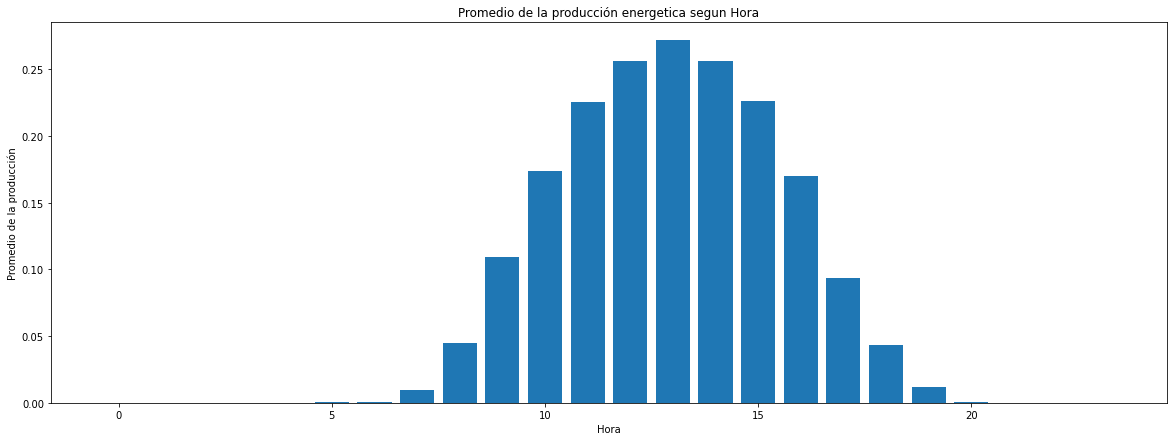

In [11]:
grafico_barras_promedio('Hora')

En este grafico de cajas veo lo mismo pero apreciando ademas la distribucion de la produccion energetica hora por hora.

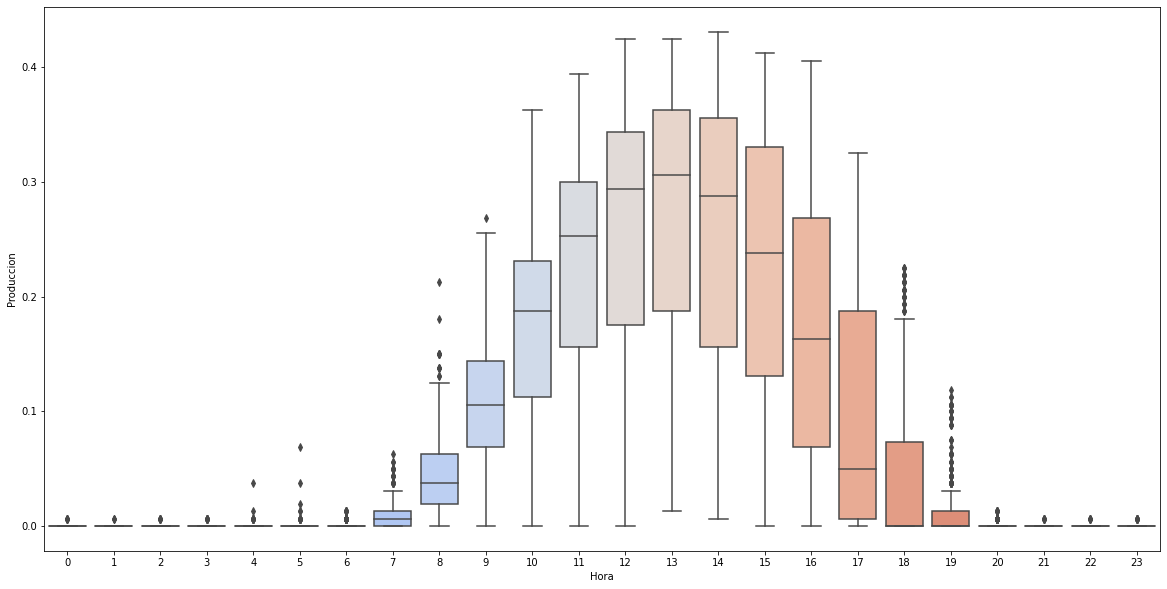

In [12]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Hora', y='Produccion', data=df_join, palette='coolwarm')
plt.xticks(np.arange(24), range(24))
plt.show()


## Meses

Repito el mismo analisis para los meses y confirmo de manera visual que en invierno se produce menos energia y que en verano la produccion es maxima.

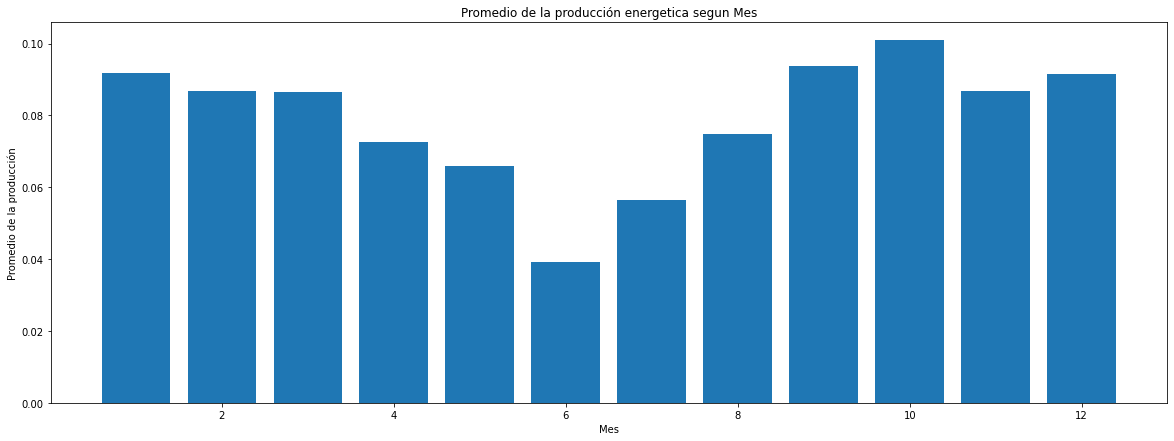

In [13]:
grafico_barras_promedio('Mes')

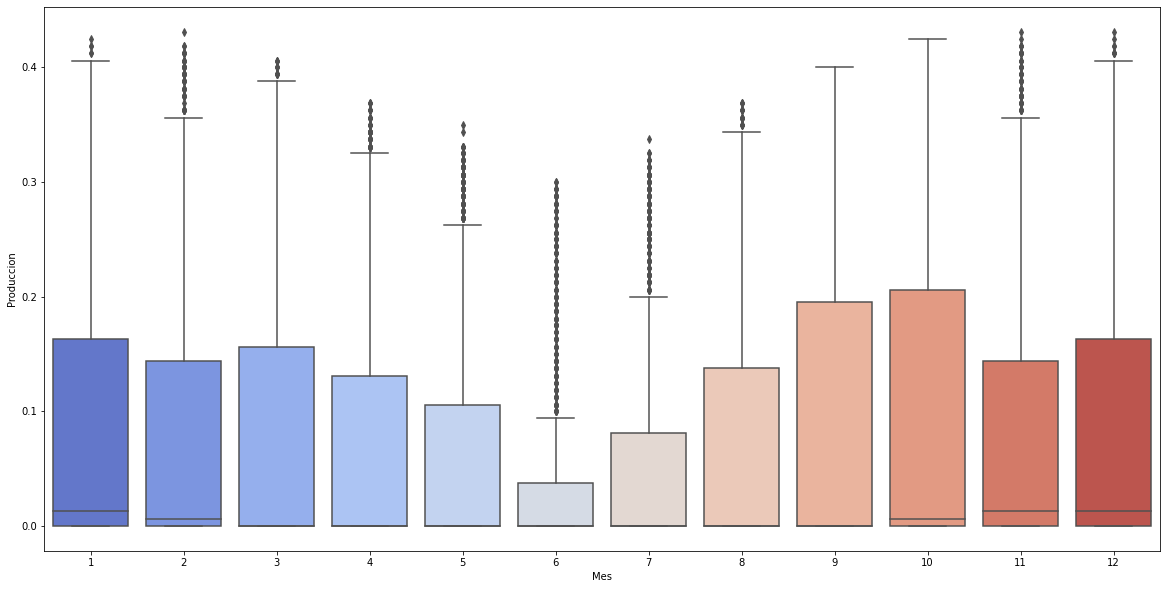

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Mes', y='Produccion', data=df_join, palette='coolwarm')
plt.xticks(np.arange(12) , range(1, 13))
plt.show()

## Clima

Cuando esta soleado la produccion de energia aumenta, y se mantiene elevada para las categorias *scattered clouds* y *passing clouds*, por el contrario cuando es *Clear* casi no hay produccion

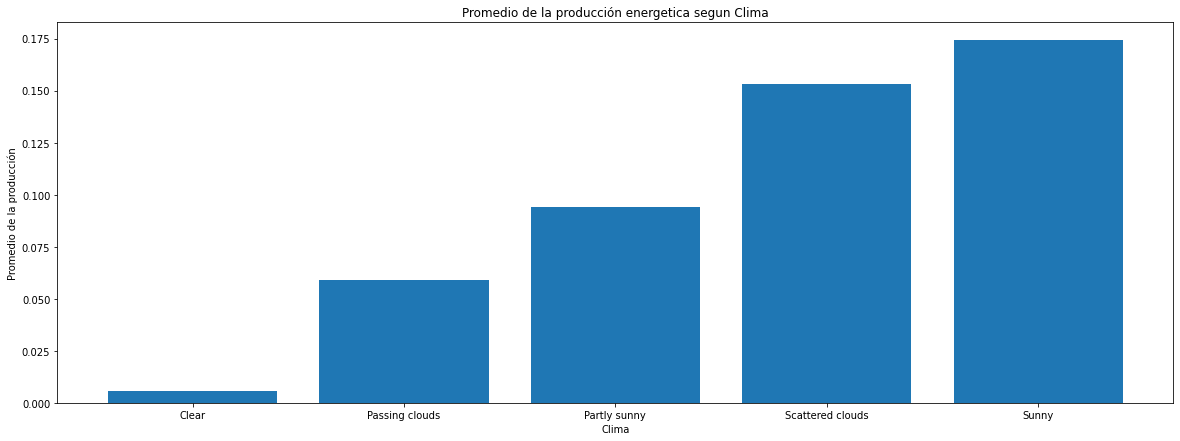

In [15]:
grafico_barras_promedio('Clima')

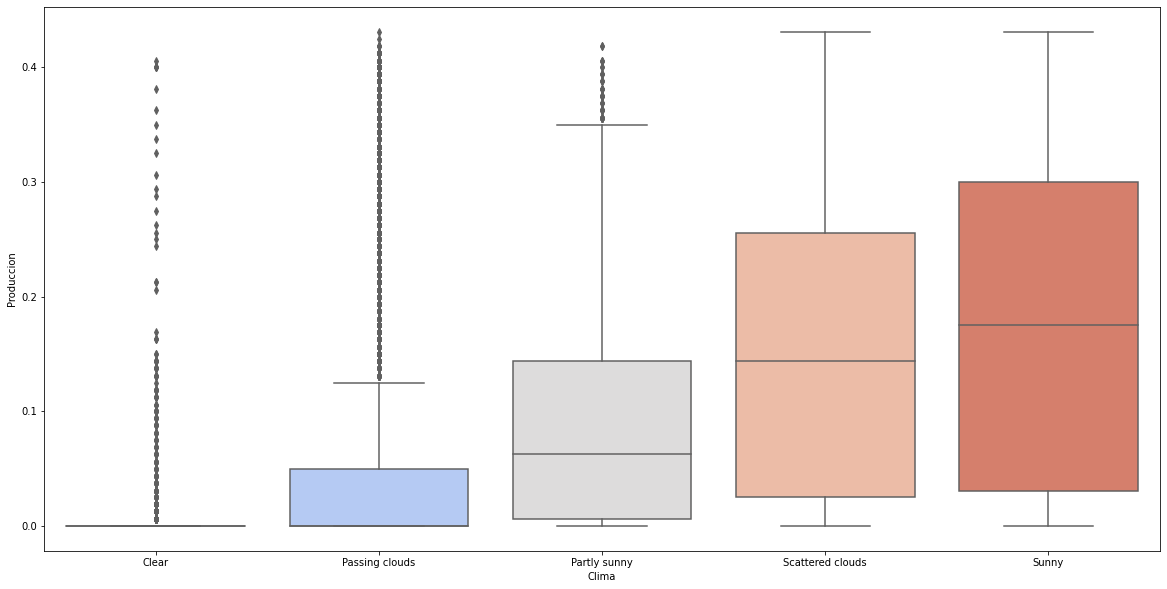

In [16]:
order = ['Clear', 'Passing clouds', 'Partly sunny', 'Scattered clouds', 'Sunny']

plt.figure(figsize=(20, 10))
sns.boxplot(x='Clima', y='Produccion', data=df_join, palette='coolwarm', order=order)
plt.show()

En el siguiente grafico se ve la relacion que hay entre el clima y la hora, mientras mas ocurrencia tenga un tipo de clima a una hora determinada mas rojo sera el recuadro.
y por lo que se ve *clear* solo ocurre de noche y tanto *Sunny*, *scattered clouds* y *partly sunny* ocurren durante las horas de luz, en cambio *passing clouds* puede ocurrir a cualquier hora del dia pero especialmente de noche


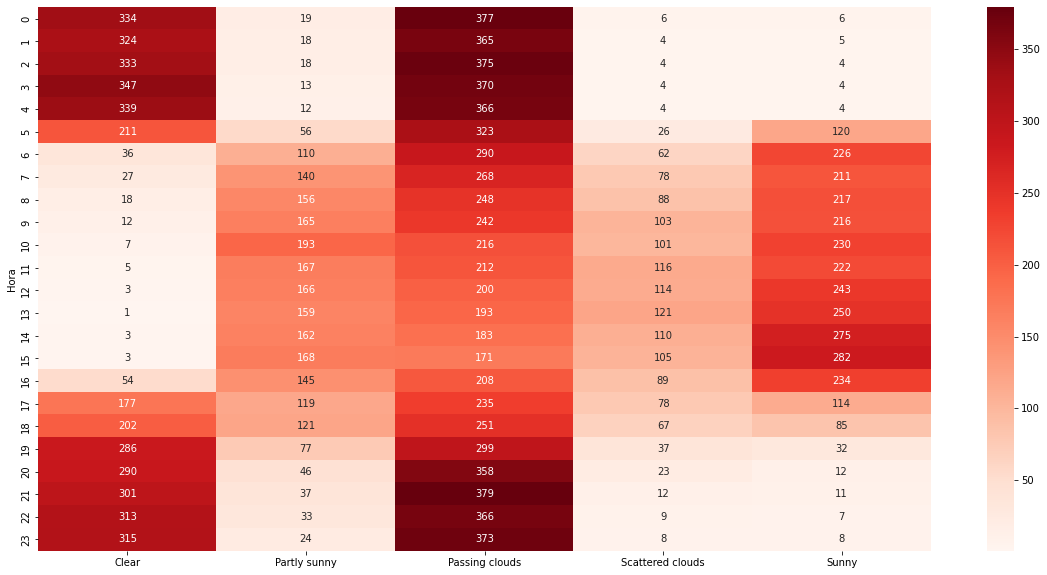

In [17]:
df_join_pivot = df_join.pivot_table(
    index=["Hora"],
    columns=["Clima"],
    values=["Produccion"],
    aggfunc="count"
)

df_join_pivot.columns = [col[1] for col in df_join_pivot.columns]

plt.figure(figsize=(20, 10))

sns.heatmap(df_join_pivot, annot=True, fmt="d",  cmap="Reds")

plt.show()

## Humedad

A priori pareceria que mientras menos humedad mas produccion de energia, por lo que seria una correlacion negativa

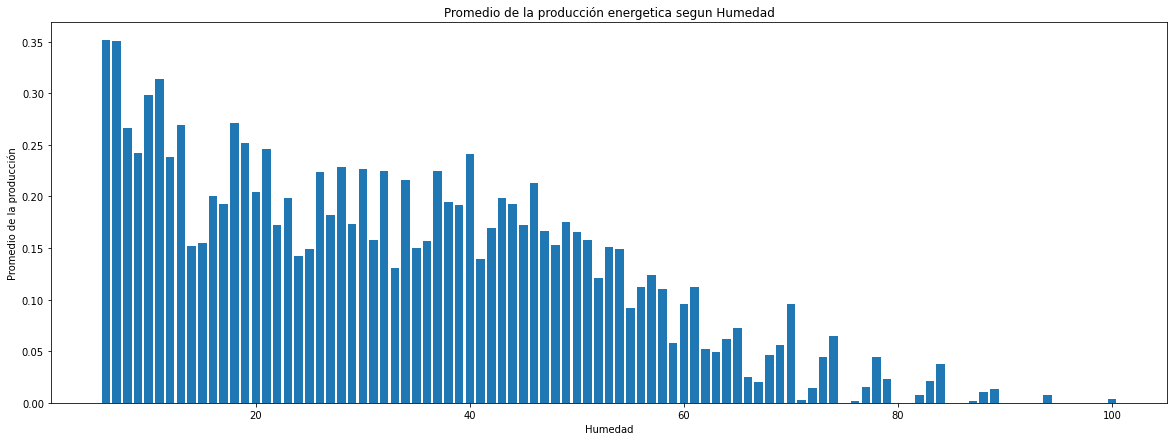

In [18]:
grafico_barras_promedio('Humedad')

## Viento

No parece haber una correlacion clara entre el viento y el promedio de produccion energetica

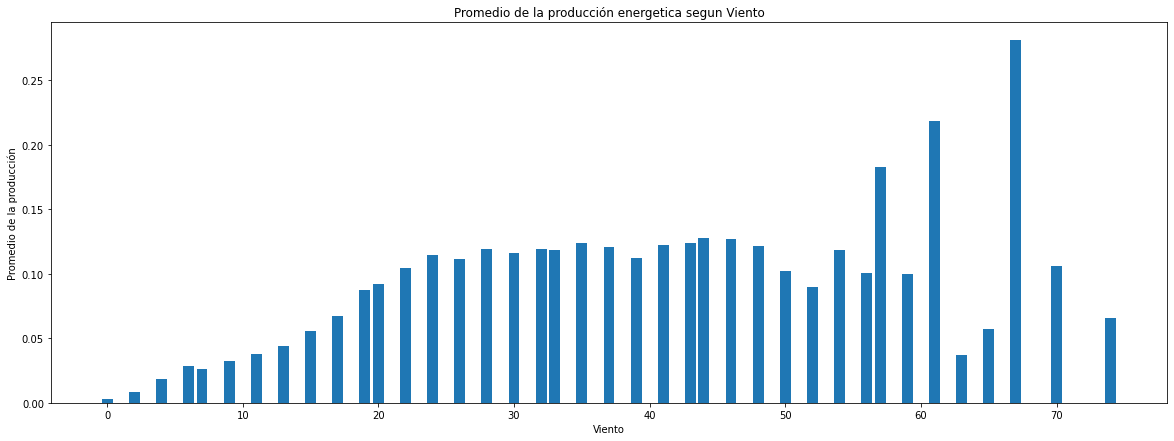

In [19]:
grafico_barras_promedio('Viento')

## Temperatura

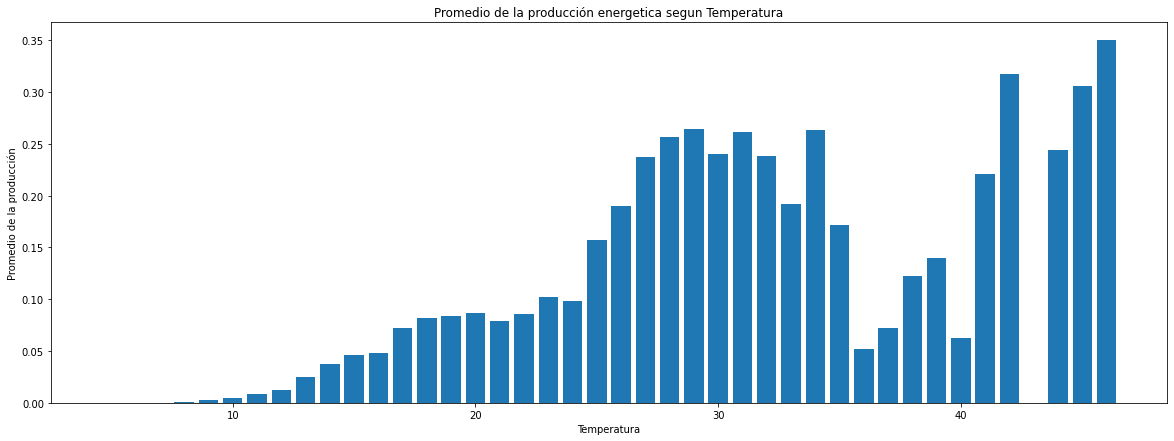

In [20]:
grafico_barras_promedio('Temperatura')

## Presion Atmosferica

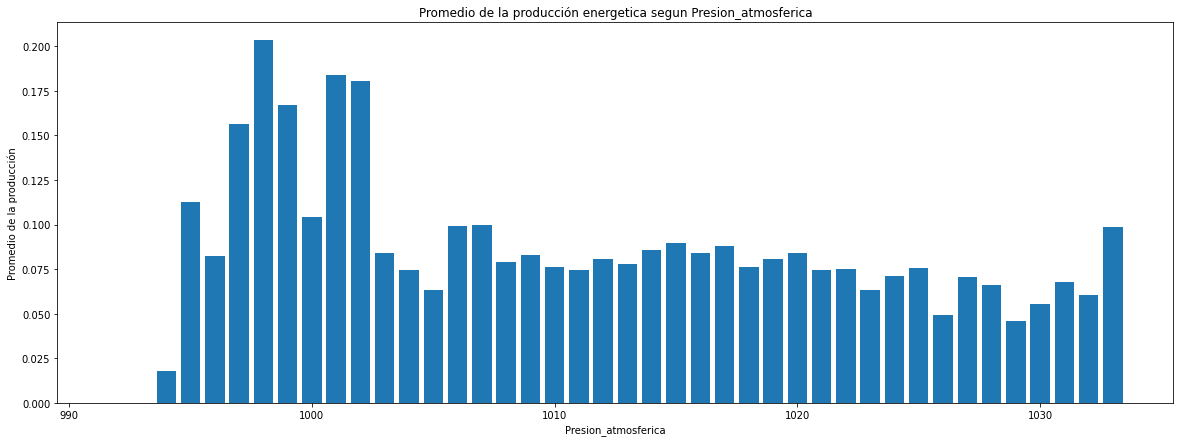

In [21]:
grafico_barras_promedio('Presion_atmosferica')

## Estacionalidad de la Serie

Analizar la estacionalidad de una serie temporal significa examinar los patrones repetitivos en la frecuencia de los datos en un período de tiempo específico, como días, meses o años. Esto puede incluir la identificación de tendencias y ciclos regulares, así como la detección de eventos puntuales, como picos o caídas en los datos.

A simple vista lo primero que se ve es que la serie esta formada por un monton de barras altas y bajas alternadamente, y que durante el verano de sidney es mas elevada la produccion y mas baja en invierno, lo cual tiene sentido.

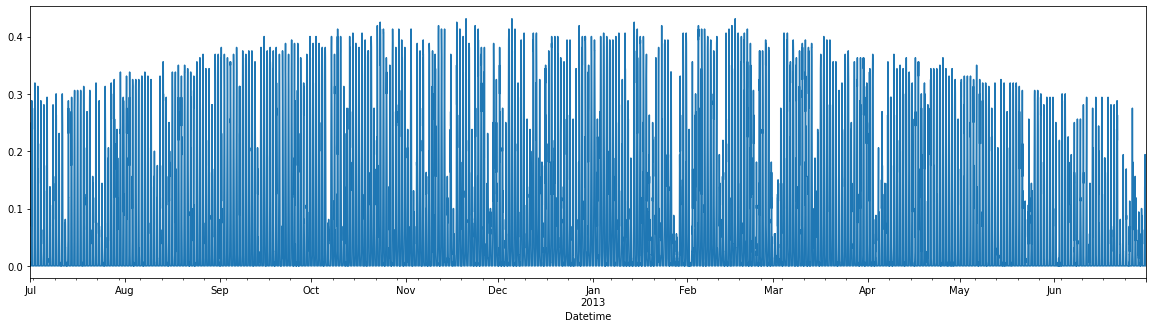

In [22]:
# grafico toda la serie completa
df_join.Produccion.plot(figsize = (20,5))

Haciendo lupa en un mes concreto se ve con muchisima mas claridad la perioricidad diaria de la serie.

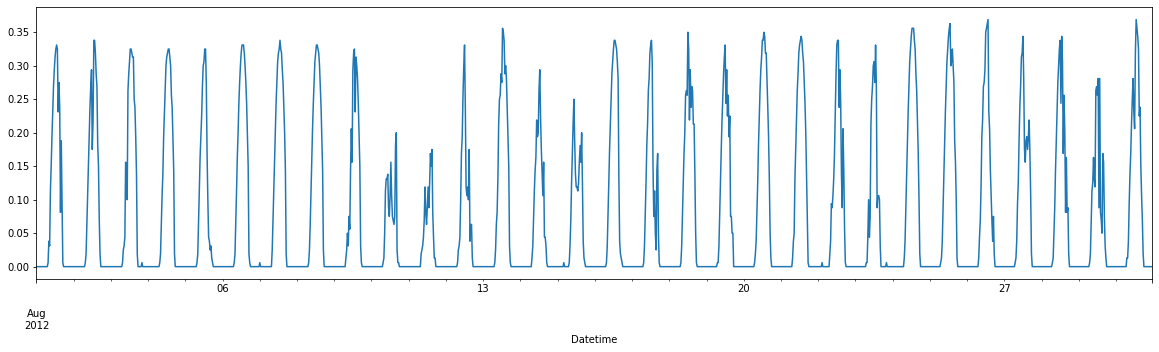

In [23]:
df_join.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'].Produccion.plot(figsize = (20,5))

Si vemos un dia en concreto se ve claramente que durante la noche no se genera energia y que en la medida de que el dia transcurre la produccion aumenta y decae nuevamente hacia la noche

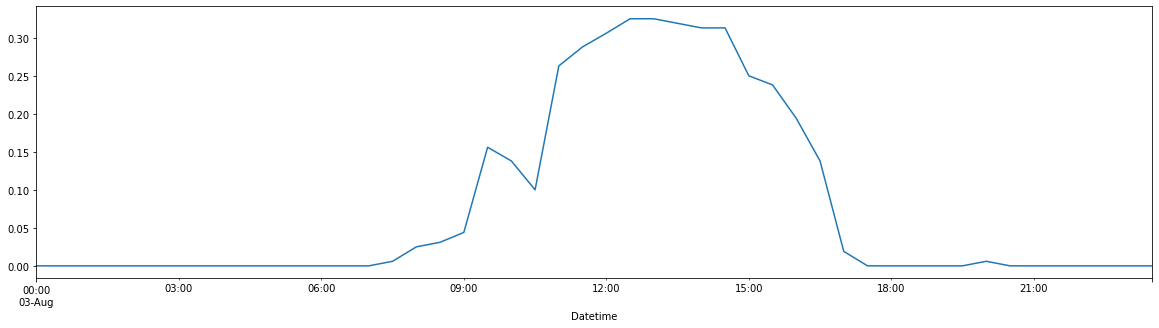

In [24]:
df_join.loc['2012-08-03 00:00:00':'2012-08-03 23:30:00'].Produccion.plot(figsize = (20,5))

### Prueba de Dickey-Fuller

El resultado del test ADF sugiere que la serie temporal es estacionaria.

El valor de p-value es de 2.07e-16, que es extremadamente pequeño y mucho menor que el nivel de significancia del 1%. Esto significa que la hipótesis nula de no-estacionariedad es rechazada con una confianza del 99%.

Por lo tanto, podemos concluir que la serie temporal es estacionaria.

In [25]:
result = adfuller(df_join.Produccion)

print("ADF: ", result[0])
print("p-value: ", result[1])
print("nobs: ", result[2])
print("critical values: ", result[4])
print("usedlag: ", result[3])

ADF:  -9.70091933085992
p-value:  1.0728026041860305e-16
nobs:  44
critical values:  {'1%': -3.4307242638530675, '5%': -2.861705410152796, '10%': -2.5668580435332715}
usedlag:  17475


<Figure size 1440x720 with 0 Axes>

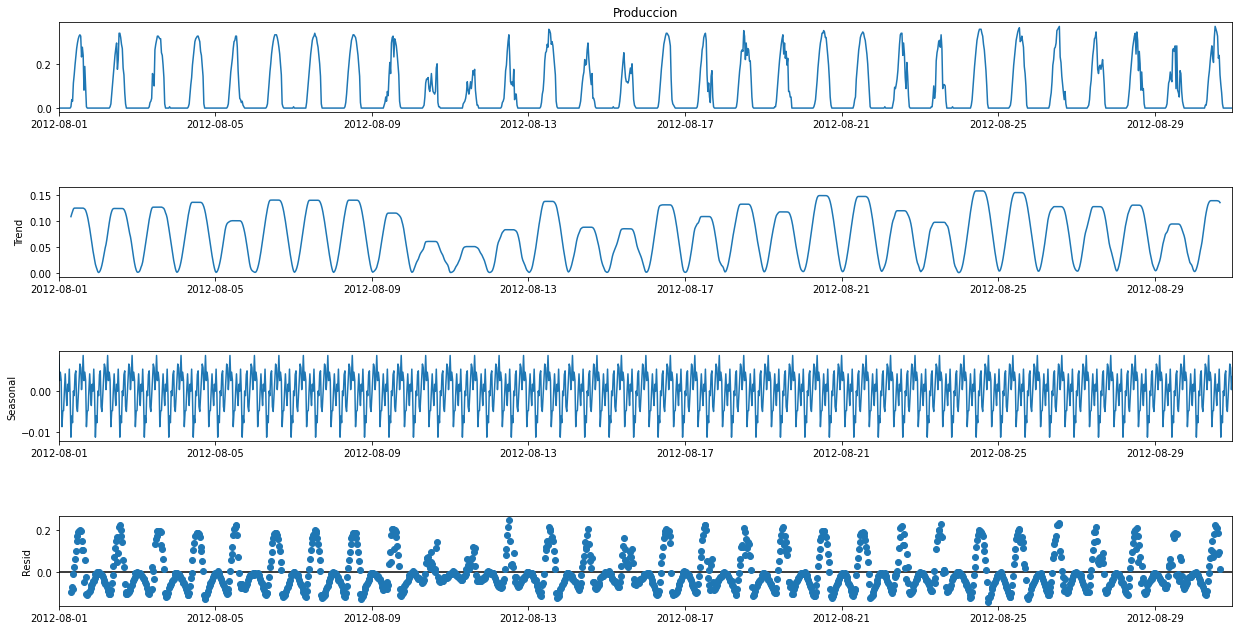

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

s_dec_additive = seasonal_decompose(df_join.Produccion.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'], model="additive", period=30)

plt.figure(figsize=(20, 10))
s_dec_additive.plot()
plt.gcf().set_size_inches(20, 10)
plt.show()





### Grafico de correlacion (ACF)

La función de autocorrelación (ACF, por sus siglas en inglés) es una medida de la correlación entre valores consecutivos de una serie temporal. En otras palabras, mide cuán relacionados están los valores de la serie en diferentes retrasos.

La ACF se representa gráficamente como una línea que muestra la correlación entre un valor de la serie y los valores que le preceden a un cierto número de períodos o retrasos (lag). Si la ACF muestra una tendencia clara a disminuir a medida que aumenta el lag, significa que la serie temporal es estacionaria y que los valores futuros están correlacionados con los valores pasados.

La ACF es útil para determinar la cantidad de autorregresión en una serie temporal y para seleccionar los valores adecuados de los parámetros p, d y q en un modelo de series temporales, como el modelo ARIMA.

La forma senoidal de esta grafica indica que hay una perioricidad en los datos, y dado que los intervalos son de media hora y que justo a los 48 intervalos se produce un ciclo completo, lo puedo interpretar como que de dia la produccion va subiendo y que en la medida que se hace de noche la produccion decrece.

<Figure size 1440x720 with 0 Axes>

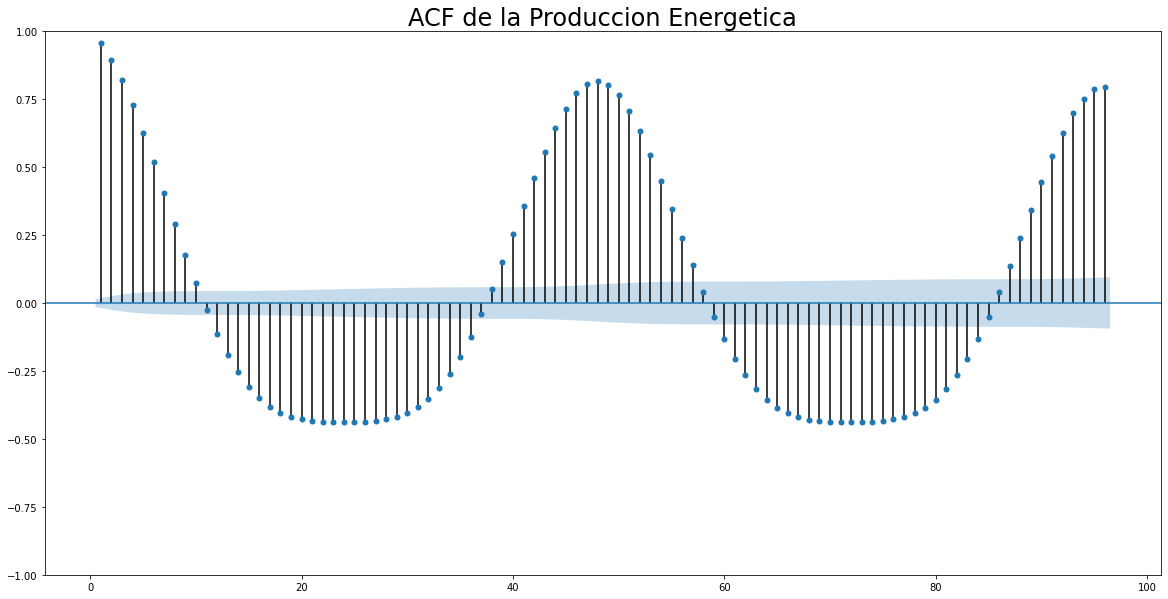

In [27]:
plt.figure(figsize=(20,10))
sgt.plot_acf(df_join.Produccion, lags = (24 * 2 * 2), zero = False)
plt.title("ACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)
plt.show()


### Grafico de autocorrelación parcial (PACF) 
La función de autocorrelación parcial (PACF) es una variante de la ACF que mide la correlación entre un valor de la serie y los valores que le preceden, después de controlar por los valores intermedios. Ambas funciones son importantes para comprender la estructura de la serie temporal y para construir modelos precisos.

Este grafico me indica que para predecir puedo usar aproximadamente entre 48 y 54 ciclos

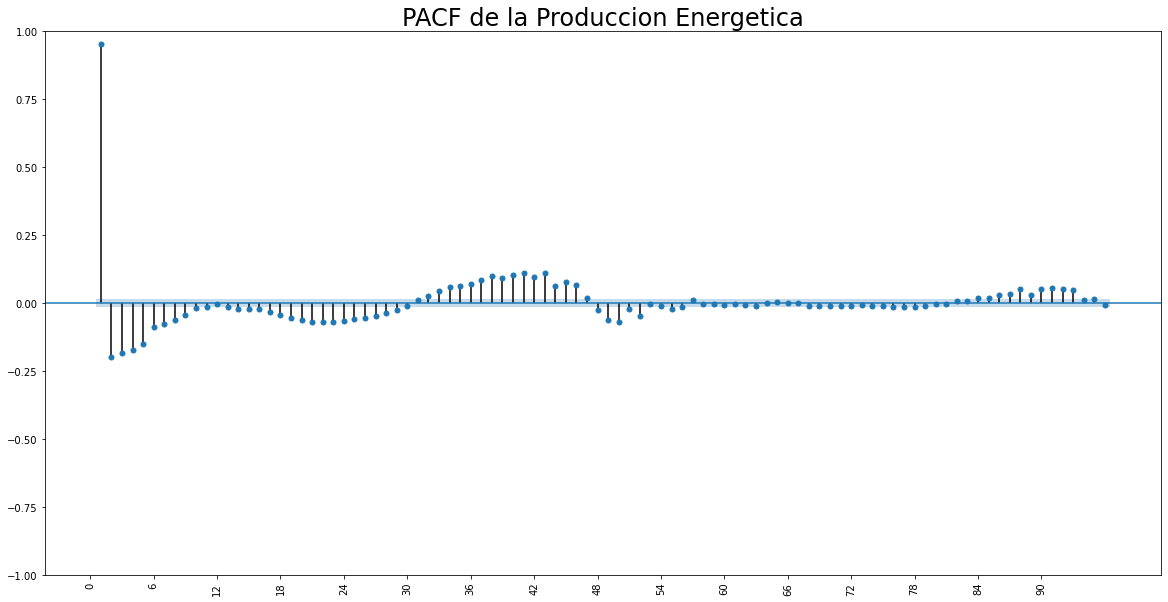

In [28]:
sgt.plot_pacf(df_join.Produccion, lags = (24 * 2 * 2), zero = False, method = ('ols'))
plt.xticks(np.arange(0, 24*2*2, 6), rotation=90)

plt.title("PACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)

plt.show()

# Modelos

Separo mi conjunto de datos en train y test

In [29]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

# Agrego una columna que le de un orden a los registros comenzando por 0 e incrementandose de 1 en 1
df_join["timeIndex"] = df_join.index - df_join.index.min()
df_join["timeIndex"] =  df_join["timeIndex"]/np.timedelta64(30, 'm')
df_join["timeIndex"] = df_join["timeIndex"].round(0).astype(int)

# guardo 1 semana de datos para testear
split = len(df_join) - (48 * 7)

df_train = df_join[:split]
df_test = df_join[split:]

print(df_train.tail(2).index)
print(df_test.head(2).index)

DatetimeIndex(['2013-06-23 23:00:00', '2013-06-23 23:30:00'], dtype='datetime64[ns]', name='Datetime', freq='30T')
DatetimeIndex(['2013-06-24 00:00:00', '2013-06-24 00:30:00'], dtype='datetime64[ns]', name='Datetime', freq='30T')


## Media constante

<ipython-input-30-de468e882619>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ProduccionMean"] = model_mean_pred


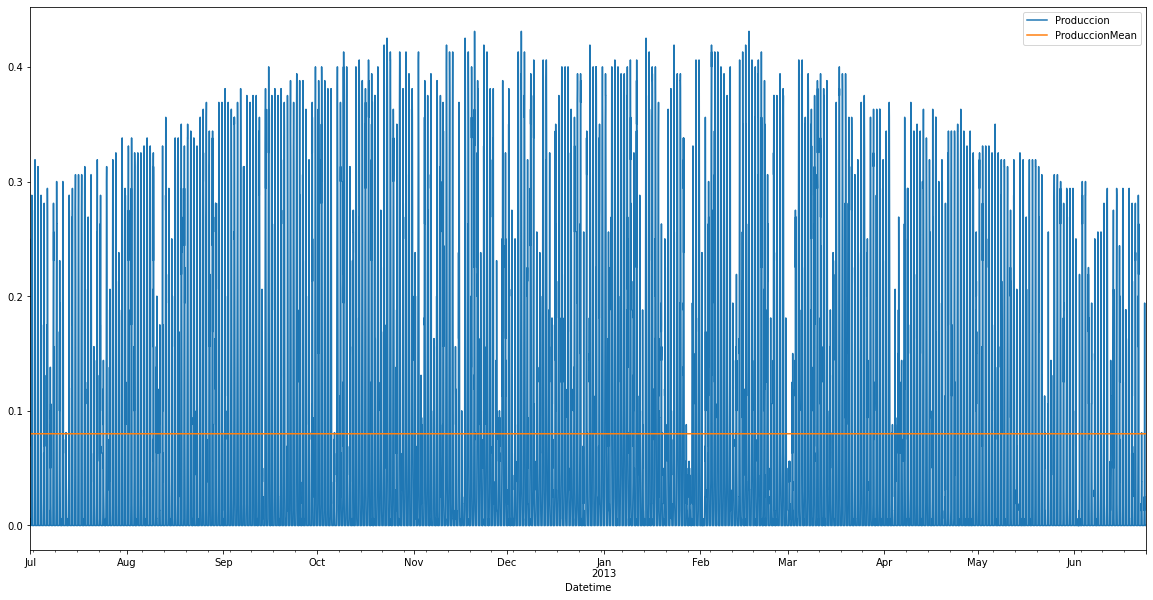

In [30]:
inicio = time.time()
model_mean_pred = df_train.Produccion.mean()
fin = time.time()

df_train["ProduccionMean"] = model_mean_pred

df_train.plot(kind="line", y = ["Produccion", "ProduccionMean"], figsize=(20,10));

Guardo el resultado en una tabla para luego hacer una comparacion entre los modelos.

In [31]:
model_mean_RMSE = RMSE(df_train.ProduccionMean, df_train.Produccion)

# Guardamos todo en un dataframe
dfModelsResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE", "Time"])
dfModelsResults.loc[0,"Model"] = "Mean"
dfModelsResults.loc[0,"Forecast"] = model_mean_pred
dfModelsResults.loc[0,"RMSE"] = model_mean_RMSE
dfModelsResults.loc[0,"Time"] = fin-inicio
dfModelsResults.head()

,Model,Forecast,RMSE,Time
0,Mean,0.080015,0.119651,0.000592


Agrego una columna que le proporcione un orden a los registros comenzando por 0 e incrementandose de 1 en 1

## Regresion Lineal

In [32]:
inicio = time.time()
model_linear = smf.ols('Produccion ~ timeIndex', data = df_train).fit()
fin = time.time()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Produccion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     19.73
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           8.99e-06
Time:                        21:49:14   Log-Likelihood:                 12111.
No. Observations:               17184   AIC:                        -2.422e+04
Df Residuals:                   17182   BIC:                        -2.420e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0870      0.002     47.703      0.000       0.083       0.091
timeIndex  -8.168e-07   1.84e-07     -4.442      0.000   -1.18e-06   -4.56e-07
==============================================================================
Omnibus:                     3052.418   Durbin-Watson:                   0.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4996.742
Skew:                           1.311   Prob(JB):                         0.00
Kurtosis:                       3.320   Cond. No.                     1.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-33-406a84af7e82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ProduccionLinear"] = model_linear_pred


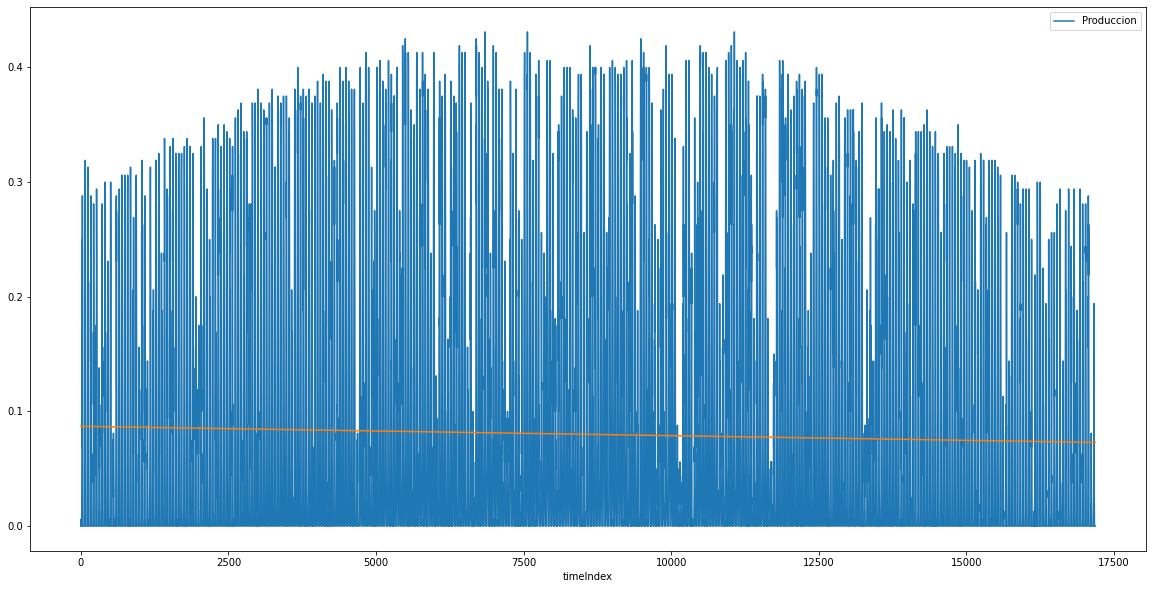

In [33]:
model_linear_pred = model_linear.predict()
df_train["ProduccionLinear"] = model_linear_pred
df_train.plot(kind="line", x="timeIndex", y = "Produccion", figsize=(20,10))
plt.plot(df_train.timeIndex,model_linear_pred, '-')

In [34]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(df_train.ProduccionLinear, df_train.Produccion)

# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
dfModelsResults.loc[1,"Model"] = "Linear"
dfModelsResults.loc[1,"Forecast"] = model_linear_pred
dfModelsResults.loc[1,"RMSE"] = model_linear_RMSE
dfModelsResults.loc[1,"Time"] = fin-inicio
dfModelsResults.head()

,Model,Forecast,RMSE,Time
0,Mean,0.080015,0.119651,0.000592
1,Linear,"[0.0870331098032746, 0.08703229297889296, 0.08...",0.119583,0.01983


## Linear + Variables endogenas

In [35]:
# Ahora estimamos una variante del modelo lineal, incluyendo las variables endogenas
inicio = time.time()
model_linear_endogenas = smf.ols('Produccion ~ timeIndex + Viento + Humedad + Presion_atmosferica + Visibilidad + Clear  + Partly_sunny + Passing_clouds + Scattered_clouds + Sunny + Hora + Mes', data = df_train).fit()
fin = time.time()
model_linear_endogenas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Produccion   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1214.
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:49:15   Log-Likelihood:                 17043.
No. Observations:               17184   AIC:                        -3.406e+04
Df Residuals:                   17172   BIC:                        -3.397e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.6673      0.101     -6.615      0.000      -0.865      -0.470
timeIndex            1.347e-06   1.65e-07      8.152      0.000    1.02e-06    1.67e-06
Viento                  0.0011   7.44e-05     15.073      0.000       0.001       0.001
Humedad                -0.0032   4.95e-05    -65.371      0.000      -0.003      -0.003
Presion_atmosferica     0.0011      0.000      8.952      0.000       0.001       0.001
Visibilidad            -0.0003      0.000     -1.331      0.183      -0.001       0.000
Clear                  -0.2155      0.020    -10.729      0.000      -0.255      -0.176
Partly_sunny           -0.1207      0.020     -5.964      0.000      -0.160      -0.081
Passing_clouds         -0.1518      0.020     -7.452      0.000      -0.192      -0.112
Scattered_clouds       -0.0800      0.021     -3.903      0.000      -0.120      -0.040
Sunny                  -0.0992      0.020     -4.955      0.000      -0.138      -0.060
Hora                 1.149e-08      0.000      0.000      1.000      -0.000       0.000
Mes                    -0.0006      0.000     -2.414      0.016      -0.001      -0.000
==============================================================================
Omnibus:                     1799.525   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2531.828
Skew:                           0.826   Prob(JB):                         0.00
Kurtosis:                       3.898   Cond. No.                     2.05e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.05e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
df_train["ProduccionLinearEndogenas"] = model_linear_endogenas.predict()
df_train.ProduccionLinearEndogenas = df_train.ProduccionLinearEndogenas.apply(lambda x: x if x>0 else 0)
model_linear_endogenas.params

<ipython-input-36-a96eb6f016a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ProduccionLinearEndogenas"] = model_linear_endogenas.predict()
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Intercept             -6.672824e-01
timeIndex              1.347226e-06
Viento                 1.120929e-03
Humedad               -3.234768e-03
Presion_atmosferica    1.058871e-03
Visibilidad           -2.901655e-04
Clear                 -2.155417e-01
Partly_sunny          -1.206729e-01
Passing_clouds        -1.518161e-01
Scattered_clouds      -8.002989e-02
Sunny                 -9.922174e-02
Hora                   1.149040e-08
Mes                   -5.574004e-04
dtype: float64

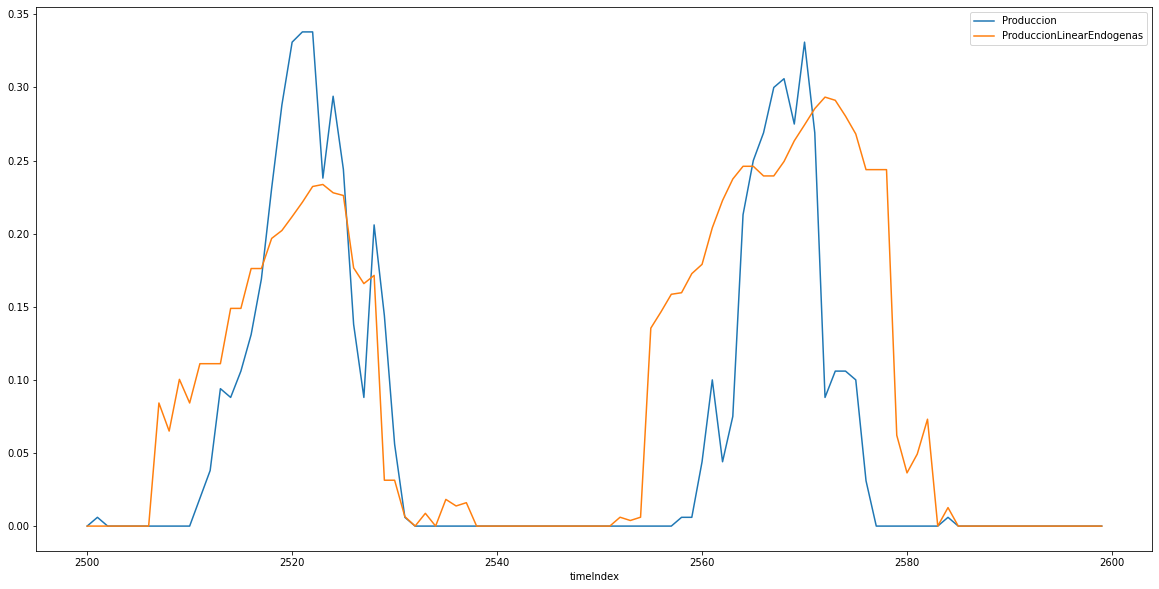

In [37]:
df_train[2500:2600].plot(kind="line", x="timeIndex", y = ["Produccion", "ProduccionLinearEndogenas"], figsize=(20,10));

In [38]:
dfModelsResults.loc[2,"Model"] = "LinearEndogenas"
dfModelsResults.loc[2,"Forecast"] = df_train.iloc[:, df_train.columns.get_loc("ProduccionLinearEndogenas")].values
dfModelsResults.loc[2,"RMSE"] = RMSE(df_train.ProduccionLinearEndogenas, df_train.Produccion)
dfModelsResults.loc[2,"Time"] = fin-inicio
dfModelsResults.head()

,Model,Forecast,RMSE,Time
0,Mean,0.080015,0.119651,0.000592
1,Linear,"[0.0870331098032746, 0.08703229297889296, 0.08...",0.119583,0.01983
2,LinearEndogenas,"[0.019979561200067164, 0.01998090842627029, 0....",0.088152,0.054546


## Media Movil - SMA (Simple Moving Averange)

<ipython-input-39-6dd989bd5ed3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ProduccionSMA48'] = df_train.Produccion.rolling(window = 48).mean().apply(lambda x: x if x>0 else 0)


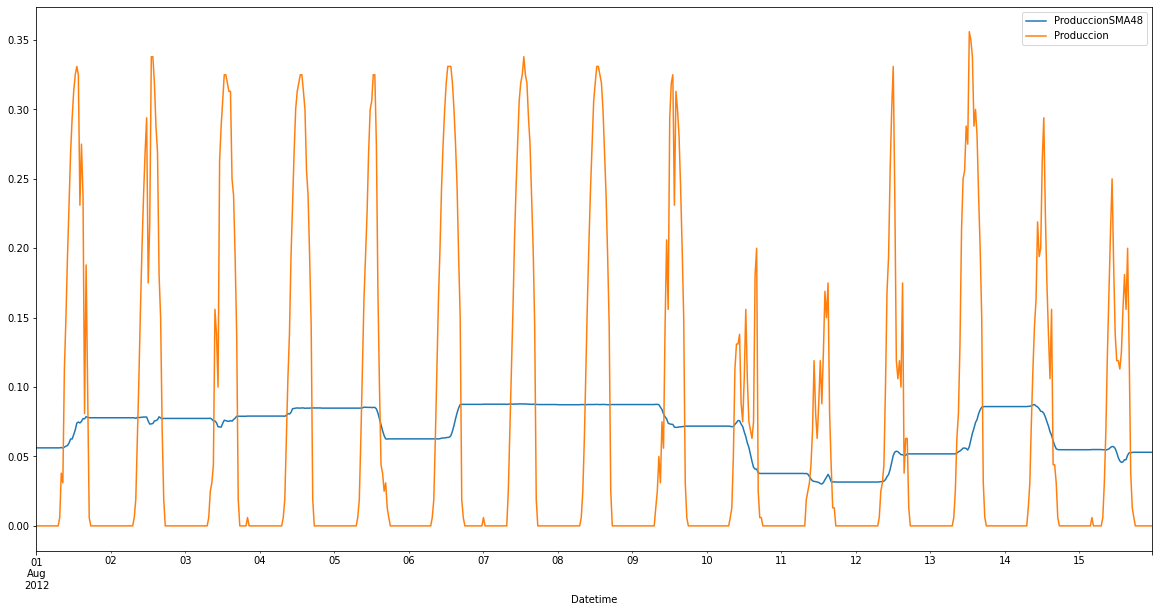

In [39]:
# Calculamos la media móvil de 12 meses para suavizar los valores y ploteamos
inicio = time.time()
df_train['ProduccionSMA48'] = df_train.Produccion.rolling(window = 48).mean().apply(lambda x: x if x>0 else 0)
fin = time.time()
df_train.loc['2012-08-01 00:00:00':'2012-08-15 23:30:00'].plot(kind ="line", y=["ProduccionSMA48", "Produccion"], figsize=(20,10));

In [40]:
dfModelsResults.loc[3,"Model"] = "SMA48"
dfModelsResults.loc[3,"Forecast"] =  0
dfModelsResults.loc[3,"RMSE"] = RMSE(df_train.ProduccionSMA48, df_train.Produccion)
dfModelsResults.loc[3,"Time"] = fin-inicio
dfModelsResults.head()

,Model,Forecast,RMSE,Time
0,Mean,0.080015,0.119651,0.000592
1,Linear,"[0.0870331098032746, 0.08703229297889296, 0.08...",0.119583,0.01983
2,LinearEndogenas,"[0.019979561200067164, 0.01998090842627029, 0....",0.088152,0.054546
3,SMA48,0,0.117695,0.036646


## Media movil exponencial - EWMA (exponentially weighted moving average)

<ipython-input-41-bf63e461c92e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ProduccionEWMA48'] = df_train.Produccion.ewm(span = 48, adjust=False).mean().apply(lambda x: x if x>0 else 0)


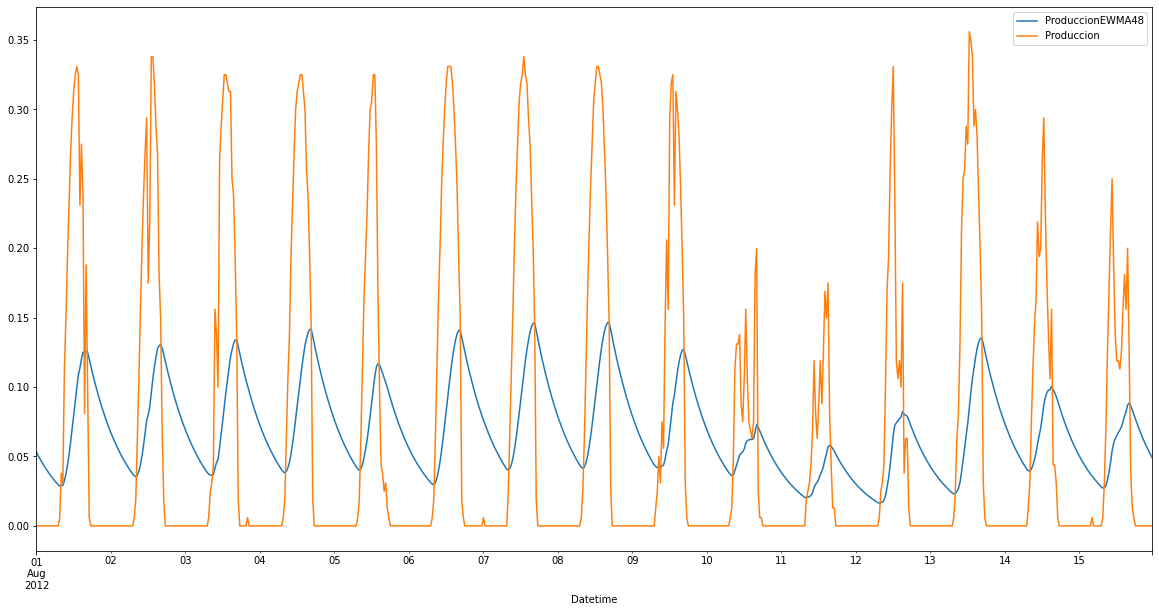

In [41]:
inicio = time.time()
df_train['ProduccionEWMA48'] = df_train.Produccion.ewm(span = 48, adjust=False).mean().apply(lambda x: x if x>0 else 0)
fin = time.time()
df_train.loc['2012-08-01 00:00:00':'2012-08-15 23:30:00'].plot(kind ="line", y=["ProduccionEWMA48", "Produccion"], figsize=(20,10));

In [42]:
dfModelsResults.loc[4,"Model"] = "EWMA48"
dfModelsResults.loc[4,"Forecast"] =  0
dfModelsResults.loc[4,"RMSE"] = RMSE(df_train.ProduccionEWMA48, df_train.Produccion)
dfModelsResults.loc[4,"Time"] = fin-inicio
dfModelsResults.head()

,Model,Forecast,RMSE,Time
0,Mean,0.080015,0.119651,0.000592
1,Linear,"[0.0870331098032746, 0.08703229297889296, 0.08...",0.119583,0.01983
2,LinearEndogenas,"[0.019979561200067164, 0.01998090842627029, 0....",0.088152,0.054546
3,SMA48,0,0.117695,0.036646
4,EWMA48,0,0.110098,0.032489


## Suavisado exponencial doble (DES - Double Exponential Smoothing)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-43-161e61ef4378>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['DES'] = modelDES.fittedvalues.shift(-1).apply(lambda x: x if x>0 else 0)


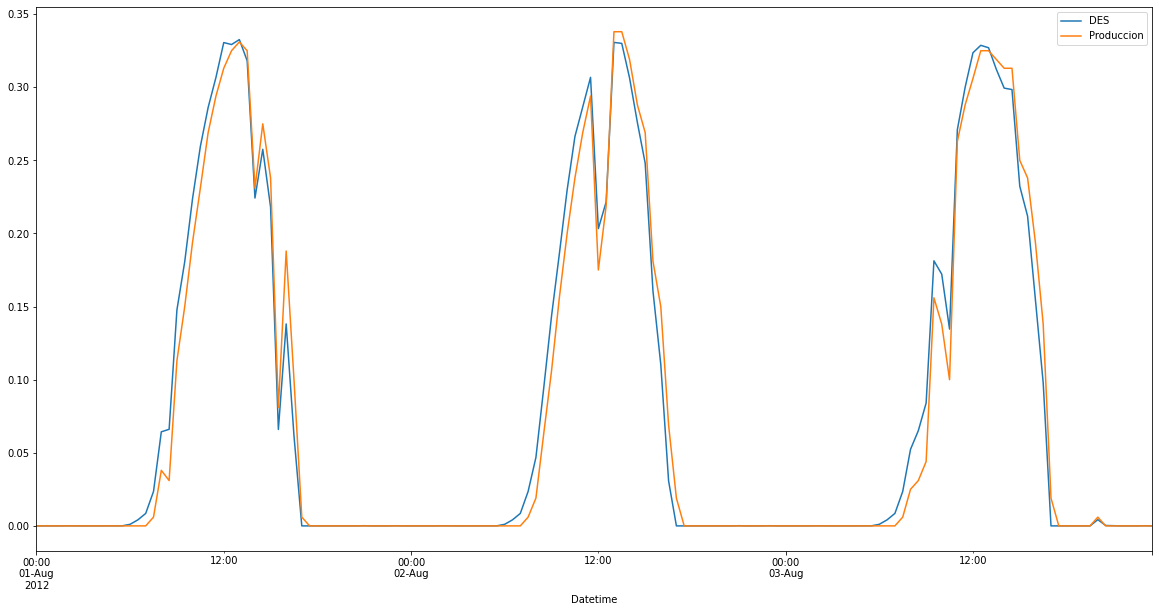

In [43]:
inicio = time.time()
modelDES = ExponentialSmoothing(df_train['Produccion'], trend='add', seasonal='add', seasonal_periods=48).fit()
df_train['DES'] = modelDES.fittedvalues.shift(-1).apply(lambda x: x if x>0 else 0)
fin = time.time()

df_train.loc['2012-08-01 00:00:00':'2012-08-03 23:30:00'].plot(kind='line', y=["DES", "Produccion"], figsize=(20,10))

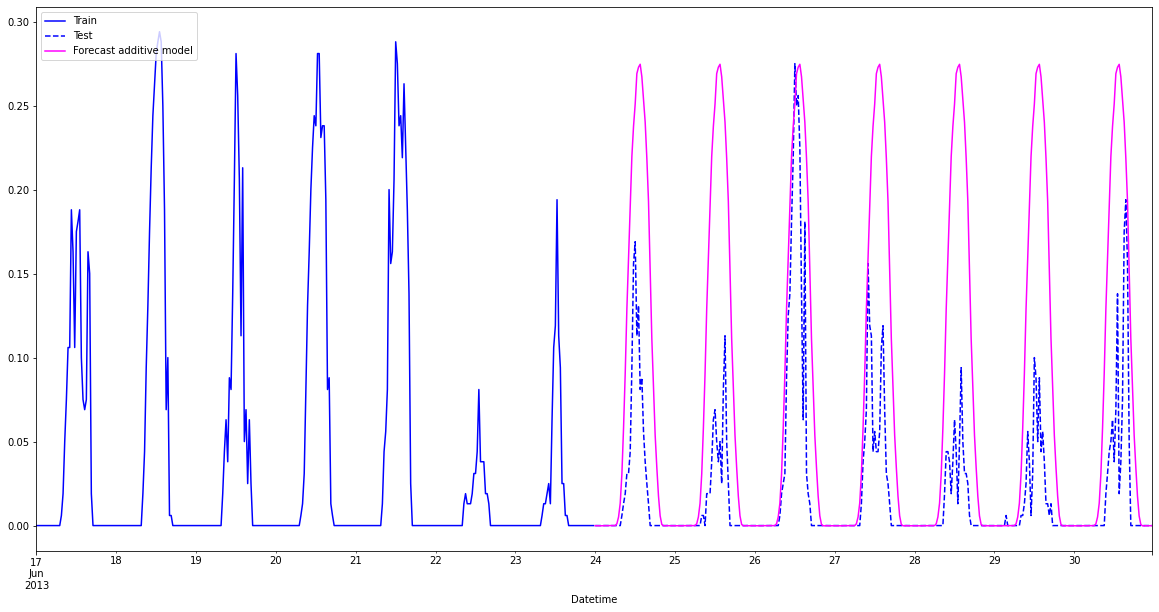

In [44]:
forecast_des =  modelDES.forecast(7*48)

df_train['Produccion'][-48*7:].plot(figsize=(20,10), label='Train', color='blue')
#df_train['DES'][-48*7:].plot(figsize=(20,10), label='prod fit', color='green')
df_test['Produccion'].plot(label='Test', color='blue', style= '--')
forecast_des.plot(label='Forecast additive model', color= 'magenta')
plt.legend(loc='upper left')


In [45]:
dfModelsResults.loc[5,"Model"] = "DES"
dfModelsResults.loc[5,"Forecast"] =  0
dfModelsResults.loc[5,"RMSE"] = RMSE(df_train.DES, df_train.Produccion)
dfModelsResults.loc[5,"Time"] = fin-inicio
dfModelsResults.head(10)

,Model,Forecast,RMSE,Time
0,Mean,0.080015,0.119651,0.000575
1,Linear,"[0.0870331098032746, 0.08703229297889296, 0.08...",0.119583,0.033523
2,LinearEndogenas,"[0.019979561200067164, 0.01998090842627029, 0....",0.088152,0.051116
3,SMA48,0,0.117695,0.010178
4,EWMA48,0,0.110098,0.011265
5,DES,0,0.016677,4.122626


## ARIMA

In [126]:
def plot_fit(model, column_name, date_from, date_to):
  df_train[column_name] = model.fittedvalues.shift(-1).apply(lambda x: x if x>0 else 0)
  df_train.Produccion.loc[date_from:date_to].plot(figsize=(20,10))
  df_train.ar_12_i_0_ma_12.loc[date_from:date_to].plot()

def plot_forecast(model, periods):
  forecast_results =  model.forecast(periods).apply(lambda x: x if x>0 else 0)

  df_train['Produccion'][-periods:].plot(figsize=(20,10), label='Train', color='blue')
  #df_train['DES'][-48*7:].plot(figsize=(20,10), label='prod fit', color='green')
  df_test['Produccion'][:periods].plot(label='Test', color='blue', style= '--')
  forecast_results.plot(label='Forecast', color= 'magenta')
  plt.legend(loc='upper left')

def plot_forecast_exog(model, periods, columns_exogenus):
  forecast_results =  model.forecast(periods, exog = df_test[columns_exogenus][:periods]).apply(lambda x: x if x>0 else 0)

  df_train['Produccion'][-periods:].plot(figsize=(20,10), label='Train', color='blue')
  #df_train['DES'][-48*7:].plot(figsize=(20,10), label='prod fit', color='green')
  df_test['Produccion'][:periods].plot(label='Test', color='blue', style= '--')
  forecast_results.plot(label='Forecast', color= 'magenta')
  plt.legend(loc='upper left')
    

In [46]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny', 'Hora', 'Mes']

df_train[columns_exog]

,Temperatura,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Hora,Mes
Datetime,,,,,,,,,,,,
2012-07-01 00:00:00,12,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7
2012-07-01 00:30:00,12,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7
2012-07-01 01:00:00,12,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-07-01 01:30:00,12,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-07-01 02:00:00,12,7,54,1014,16,1.0,0.0,0.0,0.0,0.0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-23 21:30:00,13,32,77,1026,9,0.0,0.0,1.0,0.0,0.0,21,6
2013-06-23 22:00:00,13,15,82,1026,9,0.0,0.0,1.0,0.0,0.0,22,6
2013-06-23 22:30:00,12,9,94,1026,6,0.0,0.0,1.0,0.0,0.0,22,6


### ARIMA  (12, 0, 12)

In [47]:
model_ar_12_i_0_ma_12_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, order=(12,0,12))
results_ar_12_i_0_ma_12_Xspx = model_ar_12_i_0_ma_12_Xspx.fit()
results_ar_12_i_0_ma_12_Xspx.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:               ARIMA(12, 0, 12)   Log Likelihood               34363.582
Date:                Mon, 13 Feb 2023   AIC                         -68675.163
Time:                        02:46:34   BIC                         -68473.618
Sample:                    07-01-2012   HQIC                        -68608.736
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0817      0.003     25.180      0.000       0.075       0.088
ar.L1          0.0269      2.934      0.009      0.993      -5.724       5.778
ar.L2          0.0180      2.567      0.007      0.994      -5.013       5.049
ar.L3          0.1382      1.806      0.076      0.939      -3.402       3.678
ar.L4          0.2391      1.639      0.146      0.884      -2.973       3.451
ar.L5          0.2660      0.847      0.314      0.753      -1.394       1.926
ar.L6          0.2479      1.409      0.176      0.860      -2.513       3.009
ar.L7          0.1729      0.780      0.222      0.825      -1.355       1.701
ar.L8          0.0663      1.056      0.063      0.950      -2.003       2.135
ar.L9         -0.0481      0.809     -0.059      0.953      -1.633       1.537
ar.L10        -0.1446      0.641     -0.226      0.821      -1.400       1.111
ar.L11        -0.2117      0.720     -0.294      0.769      -1.623       1.199
ar.L12        -0.2476      0.754     -0.329      0.742      -1.725       1.229
ma.L1          0.9901      2.934      0.337      0.736      -4.761       6.741
ma.L2          0.9836      0.969      1.015      0.310      -0.915       2.882
ma.L3          0.8651      2.161      0.400      0.689      -3.370       5.100
ma.L4          0.6233      0.909      0.686      0.493      -1.158       2.405
ma.L5          0.2965      1.239      0.239      0.811      -2.132       2.725
ma.L6         -0.0213      0.470     -0.045      0.964      -0.942       0.900
ma.L7         -0.2788      0.391     -0.712      0.476      -1.046       0.488
ma.L8         -0.4400      0.992     -0.444      0.657      -2.384       1.504
ma.L9         -0.4855      0.634     -0.766      0.444      -1.728       0.757
ma.L10        -0.4087      0.938     -0.436      0.663      -2.247       1.429
ma.L11        -0.2539      0.701     -0.362      0.717      -1.628       1.120
ma.L12        -0.0163      0.073     -0.222      0.824      -0.160       0.127
sigma2         0.0011   5.89e-06    182.455      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             95663.34
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.36
Prob(H) (two-sided):                  0.25   Kurtosis:                        14.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<ipython-input-62-c0bc2c5972ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[column_name] = model.fittedvalues.shift(-1).apply(lambda x: x if x>0 else 0)


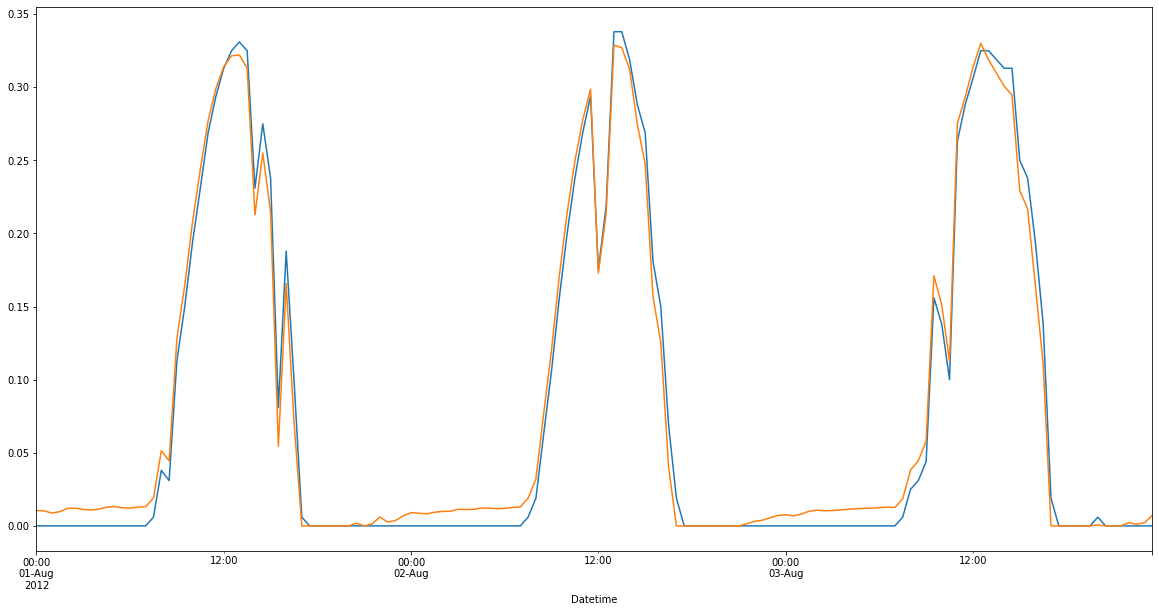

In [63]:
plot_fit(results_ar_12_i_0_ma_12_Xspx, "ar_12_i_0_ma_12", '2012-08-01 00:00:00', '2012-08-03 23:30:00')

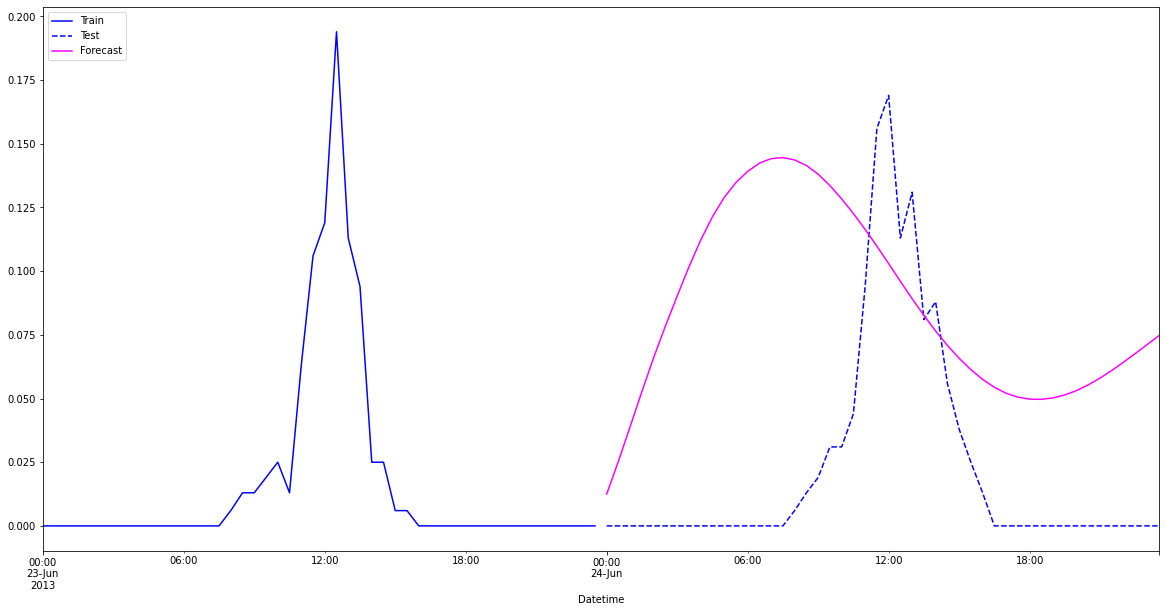

In [120]:
plot_forecast(results_ar_12_i_0_ma_12_Xspx, 48)

### ARIMA  (1, 0, 1)

In [50]:
model_ar_1_i_0_ma_1_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, order=(1,0,1))
results_ar_1_i_0_ma_1_Xspx = model_ar_1_i_0_ma_1_Xspx.fit()
results_ar_1_i_0_ma_1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(1, 0, 1)   Log Likelihood               33284.454
Date:                Mon, 13 Feb 2023   AIC                         -66560.908
Time:                        02:46:43   BIC                         -66529.902
Sample:                    07-01-2012   HQIC                        -66550.689
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0798      0.009      9.019      0.000       0.062       0.097
ar.L1          0.9411      0.004    252.612      0.000       0.934       0.948
ma.L1          0.1574      0.004     41.195      0.000       0.150       0.165
sigma2         0.0012   6.52e-06    186.564      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  10.25   Jarque-Bera (JB):             68480.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.37
Prob(H) (two-sided):                  0.94   Kurtosis:                        12.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<ipython-input-62-c0bc2c5972ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[column_name] = model.fittedvalues.shift(-1).apply(lambda x: x if x>0 else 0)


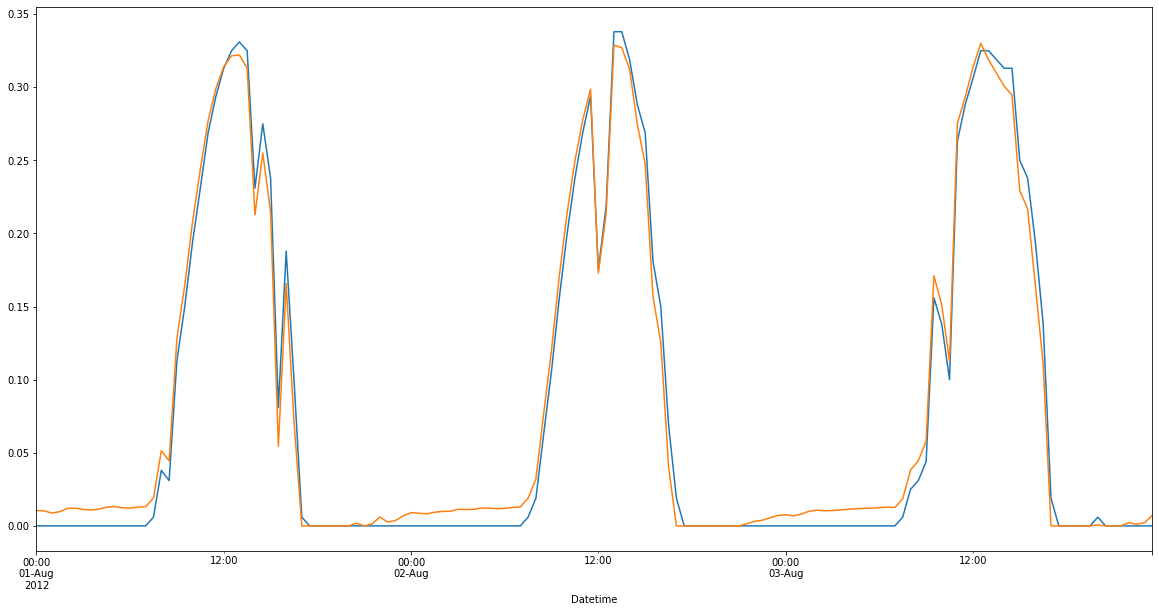

In [65]:
plot_fit(results_ar_1_i_0_ma_1_Xspx, "ar_1_i_0_ma_1", '2012-08-01 00:00:00', '2012-08-03 23:30:00')

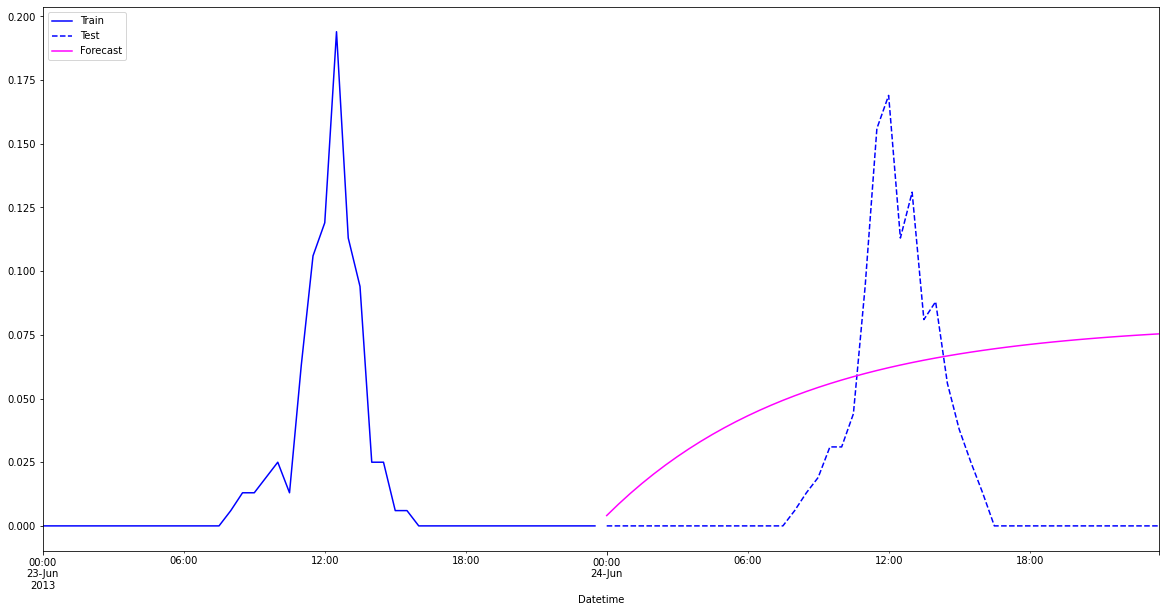

In [119]:
plot_forecast(results_ar_1_i_0_ma_1_Xspx, 48)

### ARIMA  (3, 0, 2)

In [51]:
model_ar_3_i_0_ma_2_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, order=(3,0,2))
results_ar_3_i_0_ma_2_Xspx = model_ar_3_i_0_ma_2_Xspx.fit()
results_ar_3_i_0_ma_2_Xspx.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(3, 0, 2)   Log Likelihood               32946.991
Date:                Mon, 13 Feb 2023   AIC                         -65879.983
Time:                        02:47:23   BIC                         -65825.720
Sample:                    07-01-2012   HQIC                        -65862.098
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3442      0.049      6.987      0.000       0.248       0.441
ar.L1          0.1916      0.134      1.431      0.152      -0.071       0.454
ar.L2          0.5397      0.117      4.619      0.000       0.311       0.769
ar.L3          0.2448      0.030      8.228      0.000       0.186       0.303
ma.L1          0.9315      0.134      6.953      0.000       0.669       1.194
ma.L2          0.3176      0.042      7.501      0.000       0.235       0.401
sigma2         0.0012   5.88e-06    196.905      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  11.84   Jarque-Bera (JB):             65577.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.04
Prob(H) (two-sided):                  0.88   Kurtosis:                        12.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

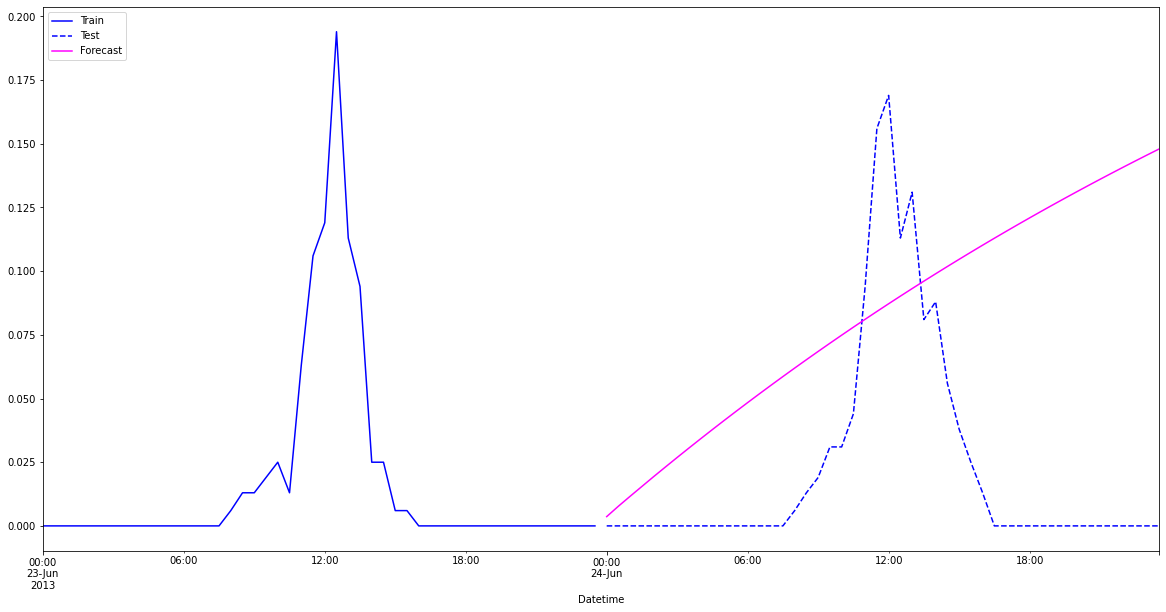

In [118]:
plot_forecast(results_ar_3_i_0_ma_2_Xspx, 48)

### ARIMA  (4, 0, 2)

In [52]:
model_ar_4_i_0_ma_2_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, order=(4,0,2))
results_ar_4_i_0_ma_2_Xspx = model_ar_4_i_0_ma_2_Xspx.fit()
results_ar_4_i_0_ma_2_Xspx.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(4, 0, 2)   Log Likelihood               34254.797
Date:                Mon, 13 Feb 2023   AIC                         -68493.595
Time:                        02:48:15   BIC                         -68431.581
Sample:                    07-01-2012   HQIC                        -68473.156
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0845      0.004     23.918      0.000       0.078       0.091
ar.L1          2.4313      0.052     46.351      0.000       2.328       2.534
ar.L2         -1.9894      0.096    -20.632      0.000      -2.178      -1.800
ar.L3          0.5730      0.042     13.608      0.000       0.490       0.656
ar.L4         -0.0318      0.007     -4.505      0.000      -0.046      -0.018
ma.L1         -1.4129      0.052    -27.199      0.000      -1.515      -1.311
ma.L2          0.5579      0.044     12.756      0.000       0.472       0.644
sigma2         0.0011   6.16e-06    178.148      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):             94806.63
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.53
Prob(H) (two-sided):                  0.35   Kurtosis:                        14.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

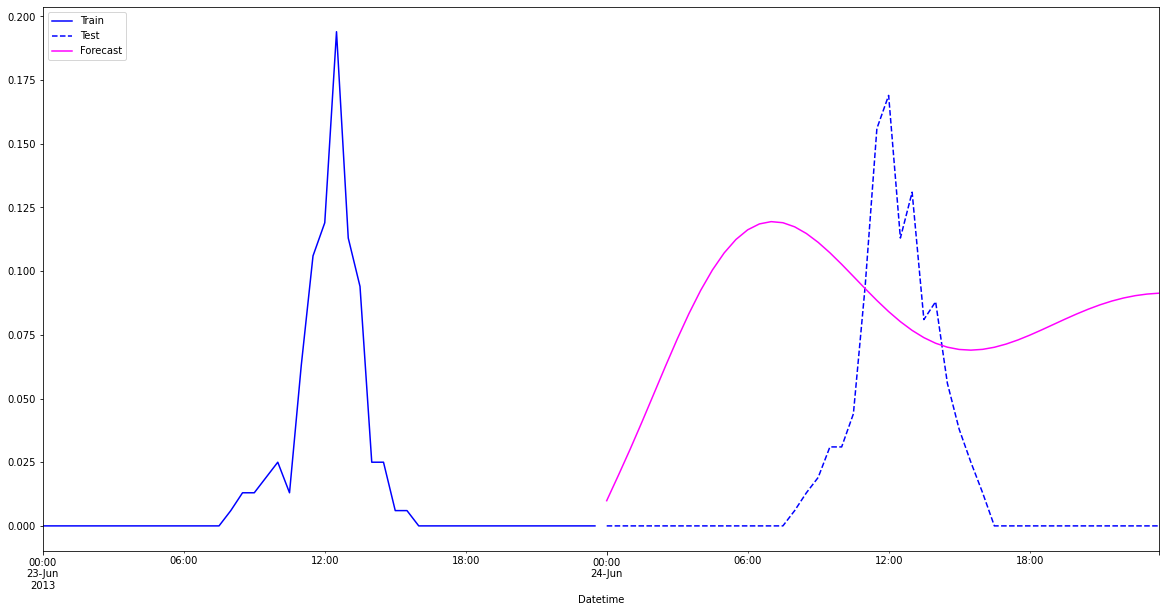

In [117]:
plot_forecast(results_ar_4_i_0_ma_2_Xspx, 48)

### ARIMA  (1, 0, 1) + Variables exogenas

In [122]:
model_ar_1_i_0_ma_1_exogenas = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog], order=(1,0,1))
results_ar_1_i_0_ma_1_exogenas = model_ar_1_i_0_ma_1_exogenas.fit()
results_ar_1_i_0_ma_1_exogenas.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(1, 0, 1)   Log Likelihood               31881.942
Date:                Mon, 13 Feb 2023   AIC                         -63731.884
Time:                        04:16:11   BIC                         -63607.857
Sample:                    07-01-2012   HQIC                        -63691.006
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4245      0.321     -7.543      0.000      -3.055      -1.795
Temperatura             0.0071      0.000     17.118      0.000       0.006       0.008
Viento                  0.0003   7.26e-05      4.305      0.000       0.000       0.000
Humedad                -0.0007   7.78e-05     -8.902      0.000      -0.001      -0.001
Presion_atmosferica     0.0028      0.000      7.572      0.000       0.002       0.004
Visibilidad          2.532e-05      0.000      0.083      0.934      -0.001       0.001
Clear                  -0.5508      0.064     -8.570      0.000      -0.677      -0.425
Partly_sunny           -0.4772      0.064     -7.418      0.000      -0.603      -0.351
Passing_clouds         -0.5025      0.064     -7.817      0.000      -0.628      -0.376
Scattered_clouds       -0.4386      0.064     -6.821      0.000      -0.565      -0.313
Sunny                  -0.4555      0.064     -7.088      0.000      -0.581      -0.330
Hora                    0.0003      0.000      1.234      0.217      -0.000       0.001
Mes                     0.0010      0.001      1.284      0.199      -0.001       0.003
ar.L1                   0.8901      0.004    243.512      0.000       0.883       0.897
ma.L1                  -0.0131      0.006     -2.335      0.020      -0.024      -0.002
sigma2                  0.0015   1.04e-05    145.815      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                 104.21   Jarque-Bera (JB):             23270.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.26
Prob(H) (two-sided):                  0.74   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.78e+16. Standard errors may be unstable.
"""

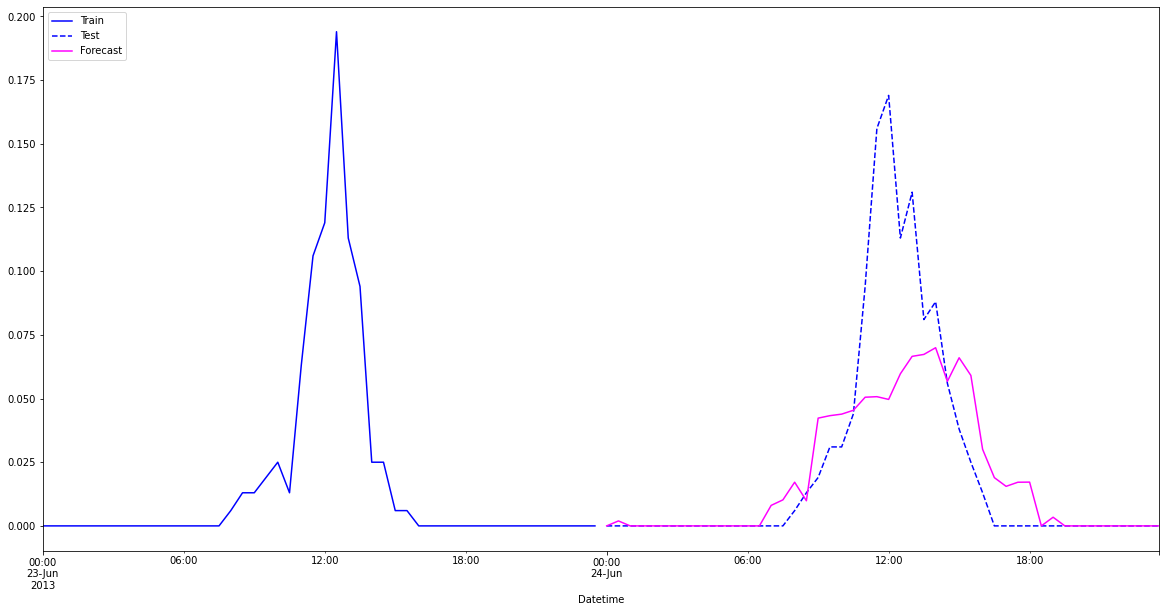

In [127]:
plot_forecast_exog(results_ar_1_i_0_ma_1_exogenas, 48, columns_exog)

In [ ]:
def plot_forecast_exog(model, periods, columns_exogenus):
  fc, se, conf =  model.forecast(periods, alpha=0.05, exog = df_test[columns_exogenus][:periods]).apply(lambda x: x if x>0 else 0)

  df_train['Produccion'][-periods:].plot(figsize=(20,10), label='Train', color='blue')
  #df_train['DES'][-48*7:].plot(figsize=(20,10), label='prod fit', color='green')
  df_test['Produccion'][:periods].plot(label='Test', color='blue', style= '--')
  fc.plot(label='Forecast', color= 'magenta')
  plt.legend(loc='upper left')

plot_forecast_exog(results_ar_1_i_0_ma_1_exogenas, 48, columns_exog)  
    

In [148]:
result

2013-06-24 00:00:00   -0.000838
2013-06-24 00:30:00    0.001948
2013-06-24 01:00:00   -0.007091
2013-06-24 01:30:00   -0.004579
2013-06-24 02:00:00   -0.001719
2013-06-24 02:30:00   -0.007712
2013-06-24 03:00:00   -0.005836
2013-06-24 03:30:00   -0.004450
2013-06-24 04:00:00   -0.005819
2013-06-24 04:30:00   -0.007771
2013-06-24 05:00:00   -0.009269
2013-06-24 05:30:00   -0.004556
2013-06-24 06:00:00   -0.003174
2013-06-24 06:30:00   -0.005391
2013-06-24 07:00:00    0.008048
2013-06-24 07:30:00    0.010217
2013-06-24 08:00:00    0.017151
2013-06-24 08:30:00    0.009867
2013-06-24 09:00:00    0.042303
2013-06-24 09:30:00    0.043271
2013-06-24 10:00:00    0.043870
2013-06-24 10:30:00    0.045392
2013-06-24 11:00:00    0.050511
2013-06-24 11:30:00    0.050727
2013-06-24 12:00:00    0.049650
2013-06-24 12:30:00    0.059717
2013-06-24 13:00:00    0.066554
2013-06-24 13:30:00    0.067315
2013-06-24 14:00:00    0.069943
2013-06-24 14:30:00    0.056724
2013-06-24 15:00:00    0.066005
2013-06-

### ARIMA  (1, 0, 1) + Variables exogenas 2

In [124]:
columns_exog_2 = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

model_ar_1_i_0_ma_1_exogenas_2 = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog_2], order=(1,0,1))
results_ar_1_i_0_ma_1_exogenas_2 = model_ar_1_i_0_ma_1_exogenas_2.fit()
results_ar_1_i_0_ma_1_exogenas_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(1, 0, 1)   Log Likelihood               31850.275
Date:                Mon, 13 Feb 2023   AIC                         -63674.549
Time:                        04:19:11   BIC                         -63573.777
Sample:                    07-01-2012   HQIC                        -63641.335
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.3156      0.306     -7.578      0.000      -2.915      -1.717
Temperatura             0.0075      0.000     19.380      0.000       0.007       0.008
Viento                 -0.0001   6.83e-05     -1.674      0.094      -0.000    1.96e-05
Humedad                -0.0005   7.41e-05     -7.113      0.000      -0.001      -0.000
Presion_atmosferica     0.0027      0.000      7.583      0.000       0.002       0.003
Clear                  -0.5299      0.061     -8.674      0.000      -0.650      -0.410
Partly_sunny           -0.4552      0.061     -7.440      0.000      -0.575      -0.335
Passing_clouds         -0.4805      0.061     -7.860      0.000      -0.600      -0.361
Scattered_clouds       -0.4171      0.061     -6.822      0.000      -0.537      -0.297
Sunny                  -0.4329      0.061     -7.089      0.000      -0.553      -0.313
ar.L1                   0.8899      0.003    259.963      0.000       0.883       0.897
ma.L1                  -0.0090      0.005     -1.677      0.094      -0.019       0.002
sigma2                  0.0015   9.64e-06    151.427      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                 110.16   Jarque-Bera (JB):             23212.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.28
Prob(H) (two-sided):                  0.77   Kurtosis:                         8.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.32e+16. Standard errors may be unstable.
"""

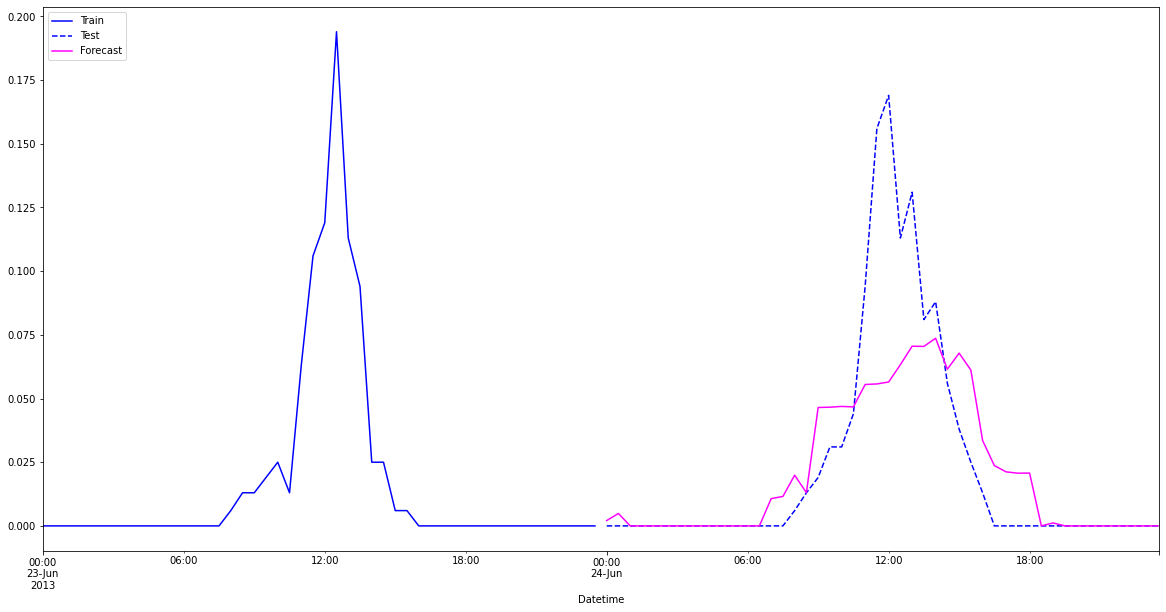

In [128]:
plot_forecast_exog(results_ar_1_i_0_ma_1_exogenas_2, 48, columns_exog_2)

### ARIMA  (1, 0, 1) + Variables exogenas 3

In [129]:
columns_exog_3 = ['Temperatura', 'Humedad',
       'Presion_atmosferica', 'Clear', 'Partly_sunny',
       'Passing_clouds', 'Scattered_clouds', 'Sunny']

model_ar_1_i_0_ma_1_exogenas_3 = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog_3], order=(1,0,1))
results_ar_1_i_0_ma_1_exogenas_3 = model_ar_1_i_0_ma_1_exogenas_3.fit()
results_ar_1_i_0_ma_1_exogenas_3.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(1, 0, 1)   Log Likelihood               33284.151
Date:                Mon, 13 Feb 2023   AIC                         -66544.301
Time:                        04:23:08   BIC                         -66451.280
Sample:                    07-01-2012   HQIC                        -66513.642
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9508      0.265     -7.363      0.000      -2.470      -1.431
Temperatura             0.0118      0.000     33.236      0.000       0.011       0.013
Humedad                -0.0002   6.72e-05     -2.238      0.025      -0.000   -1.87e-05
Presion_atmosferica     0.0022      0.000      6.988      0.000       0.002       0.003
Clear                  -0.4132      0.053     -7.802      0.000      -0.517      -0.309
Partly_sunny           -0.3815      0.053     -7.193      0.000      -0.486      -0.278
Passing_clouds         -0.3853      0.053     -7.268      0.000      -0.489      -0.281
Scattered_clouds       -0.3777      0.053     -7.121      0.000      -0.482      -0.274
Sunny                  -0.3931      0.053     -7.424      0.000      -0.497      -0.289
ar.L1                   0.8890      0.003    300.272      0.000       0.883       0.895
ma.L1                  -0.0061      0.005     -1.332      0.183      -0.015       0.003
sigma2                  0.0012   6.37e-06    185.060      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                 504.09   Jarque-Bera (JB):             36361.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.50
Prob(H) (two-sided):                  0.45   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.64e+16. Standard errors may be unstable.
"""

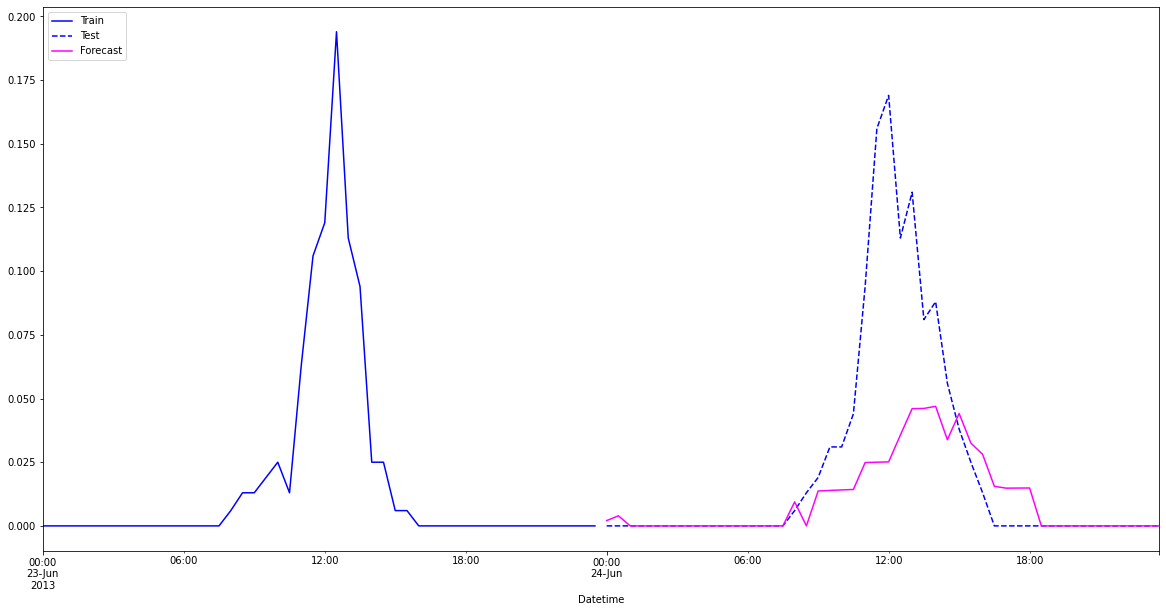

In [130]:
plot_forecast_exog(results_ar_1_i_0_ma_1_exogenas_3, 48, columns_exog_3)

### ARIMA  (2, 0, 4) + Variables exogenas 3

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(2, 0, 4)   Log Likelihood               32113.360
Date:                Mon, 13 Feb 2023   AIC                         -64194.719
Time:                        04:43:04   BIC                         -64070.691
Sample:                    07-01-2012   HQIC                        -64153.841
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9522      0.197     -9.909      0.000      -2.338      -1.566
Temperatura             0.0087      0.000     29.501      0.000       0.008       0.009
Humedad         

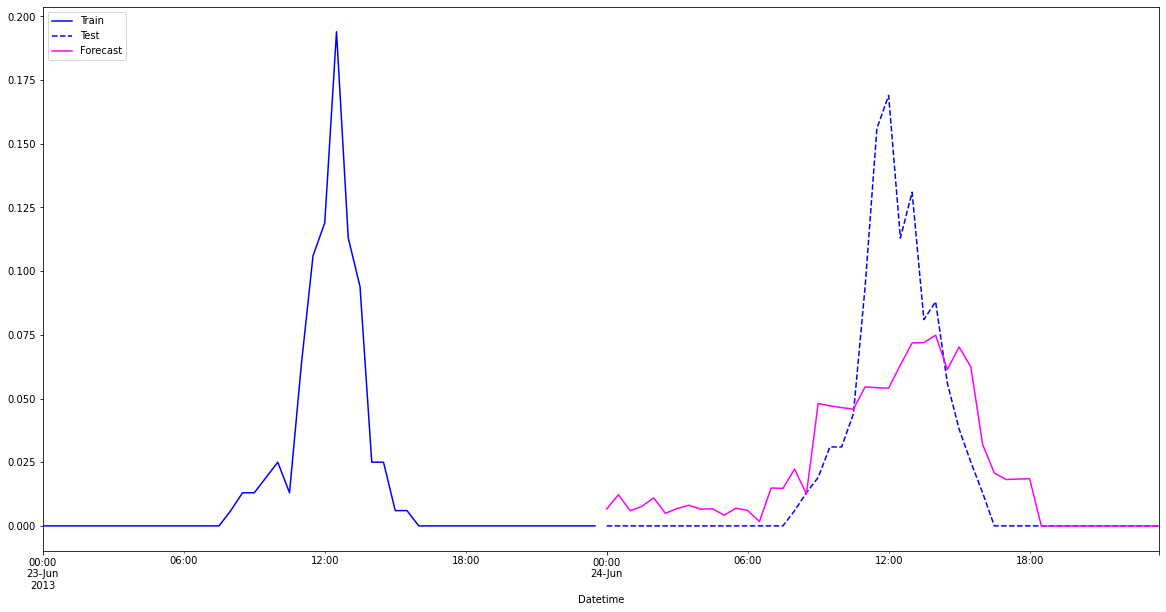

In [140]:
modelo_xx = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog_3], order=(2,0,4))
results_modelo_xx = modelo_xx.fit()
print(results_modelo_xx.summary())
plot_forecast_exog(results_modelo_xx, 48, columns_exog_3)

### ARIMA  (3, 0, 4) + Variables exogenas 3

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(3, 0, 4)   Log Likelihood               32023.404
Date:                Mon, 13 Feb 2023   AIC                         -64012.808
Time:                        04:46:04   BIC                         -63881.028
Sample:                    07-01-2012   HQIC                        -63969.375
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9523      0.223     -8.736      0.000      -2.390      -1.514
Temperatura             0.0062      0.000     19.152      0.000       0.006       0.007
Humedad         

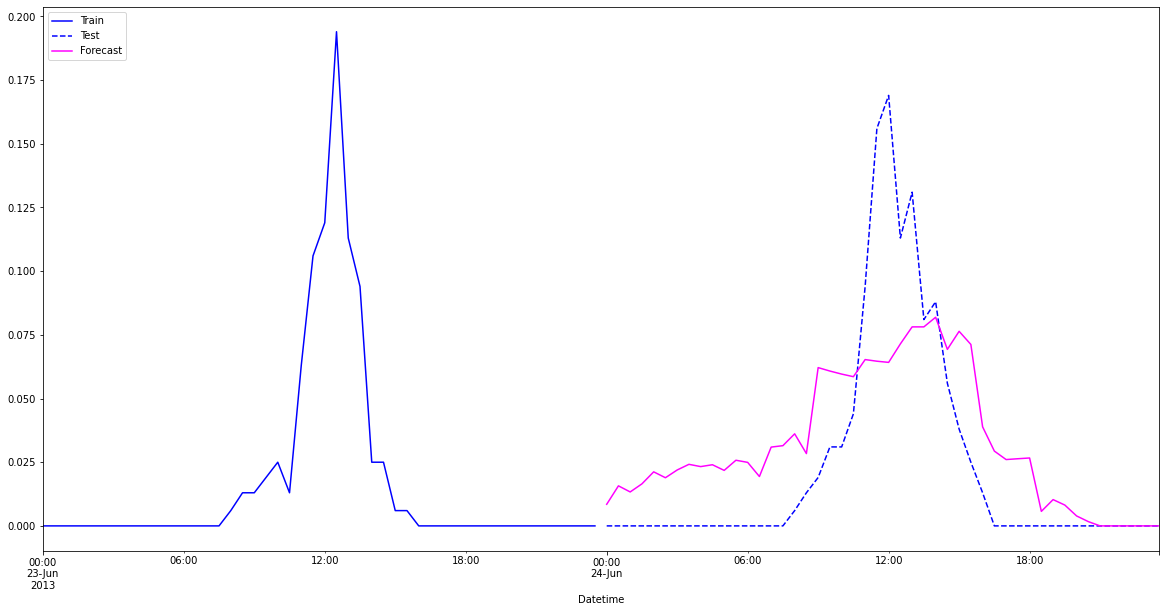

In [141]:
modelo_xx = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog_3], order=(3,0,4))
results_modelo_xx = modelo_xx.fit()
print(results_modelo_xx.summary())
plot_forecast_exog(results_modelo_xx, 48, columns_exog_3)

### ARIMA  (4, 0, 4) + Variables exogenas 3

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(4, 0, 4)   Log Likelihood               31999.478
Date:                Mon, 13 Feb 2023   AIC                         -63962.956
Time:                        04:48:52   BIC                         -63823.425
Sample:                    07-01-2012   HQIC                        -63916.968
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9523      0.225     -8.684      0.000      -2.393      -1.512
Temperatura             0.0062      0.000     18.563      0.000       0.006       0.007
Humedad         

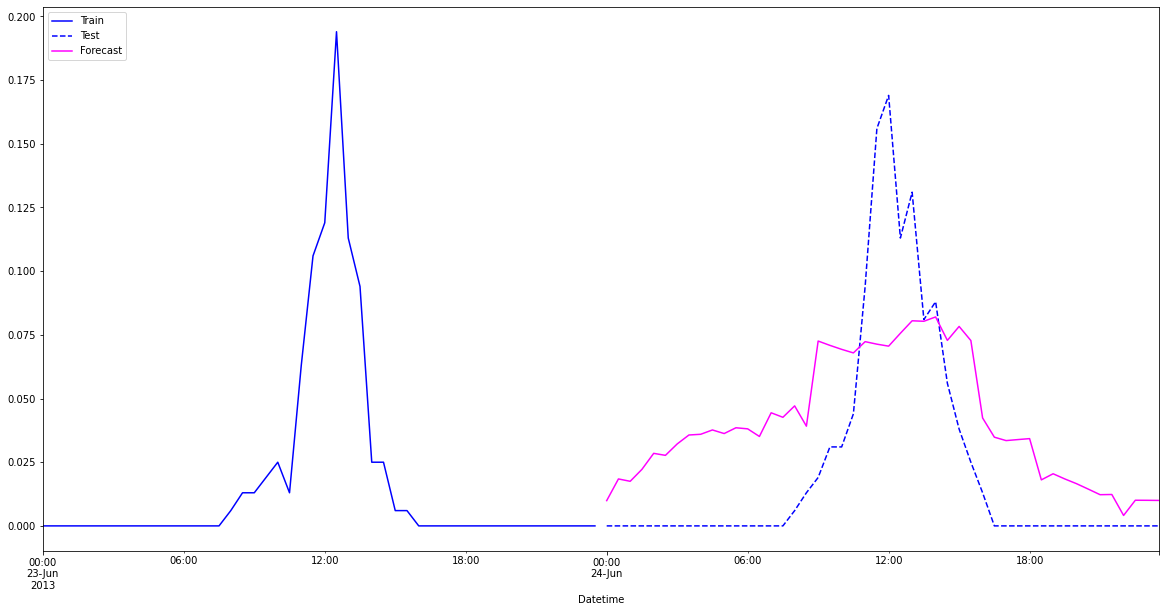

In [142]:
modelo_xx = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog_3], order=(4,0,4))
results_modelo_xx = modelo_xx.fit()
print(results_modelo_xx.summary())
plot_forecast_exog(results_modelo_xx, 48, columns_exog_3)

### ARIMA  (1, 1, 1) + Variables exogenas

In [54]:
model_ar_1_i_1_ma_1_exogenas = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog], order=(1,1,1))
results_ar_1_i_1_ma_1_exogenas = model_ar_1_i_1_ma_1_exogenas.fit()
results_ar_1_i_1_ma_1_exogenas.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(1, 1, 1)   Log Likelihood               33587.822
Date:                Mon, 13 Feb 2023   AIC                         -67145.645
Time:                        02:50:53   BIC                         -67029.370
Sample:                    07-01-2012   HQIC                        -67107.322
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0112      0.000     27.218      0.000       0.010       0.012
Viento                  0.0003   5.96e-05      5.665      0.000       0.000       0.000
Humedad                 0.0002   7.52e-05      2.898      0.004    7.05e-05       0.000
Presion_atmosferica    -0.0014      0.001     -2.592      0.010      -0.002      -0.000
Visibilidad            -0.0004      0.000     -1.278      0.201      -0.001       0.000
Clear                  -0.0044      0.002     -2.732      0.006      -0.008      -0.001
Partly_sunny           -0.0079      0.001     -8.816      0.000      -0.010      -0.006
Passing_clouds          0.0008      0.001      0.935      0.350      -0.001       0.002
Scattered_clouds        0.0045      0.001      5.539      0.000       0.003       0.006
Sunny                   0.0065      0.001      6.640      0.000       0.005       0.008
Hora                   -0.0001      0.000     -0.450      0.653      -0.001       0.000
Mes                     0.0002      0.058      0.003      0.998      -0.113       0.113
ar.L1                   0.0395      0.054      0.734      0.463      -0.066       0.145
ma.L1                   0.0392      0.053      0.742      0.458      -0.064       0.143
sigma2                  0.0012    5.7e-06    206.050      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             68333.11
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.44   Kurtosis:                        12.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+19. Standard errors may be unstable.
"""

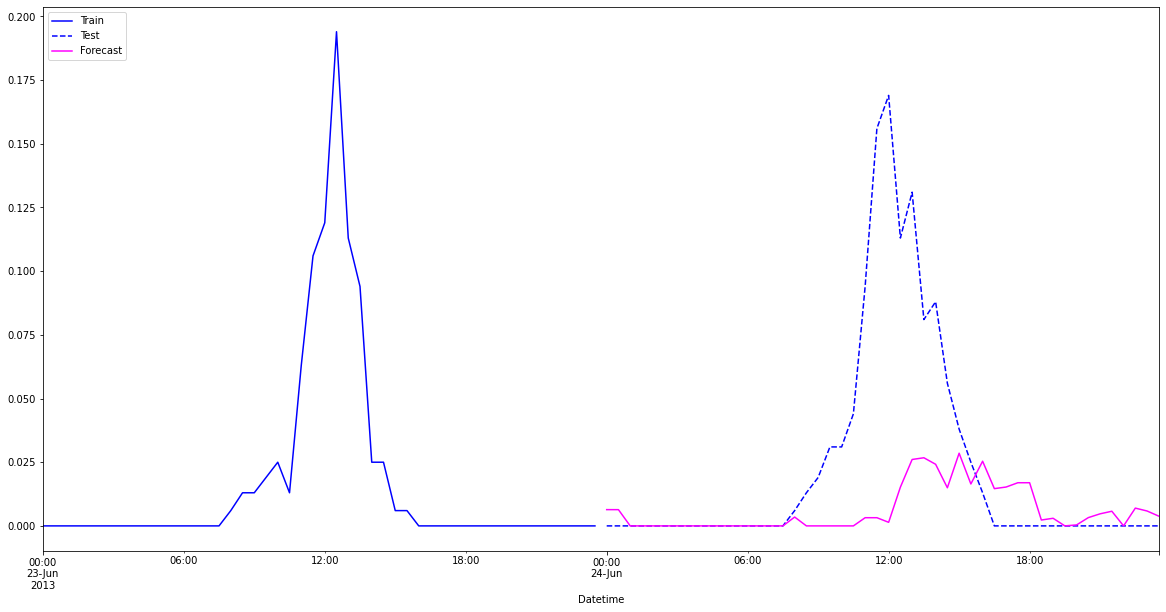

In [115]:
plot_forecast_exog(results_ar_1_i_1_ma_1_exogenas, 48)

### ARIMA  (24, 0, 24) + Variables exogenas

In [55]:
model_ar_24_i_1_ma_24_exogenas = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog], order=(24,0,24))
results_ar_24_i_1_ma_24_exogenas = model_ar_24_i_1_ma_24_exogenas.fit()
results_ar_24_i_1_ma_24_exogenas.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:               ARIMA(24, 0, 24)   Log Likelihood               -3883.645
Date:                Mon, 13 Feb 2023   AIC                           7891.290
Time:                        02:57:03   BIC                           8371.898
Sample:                    07-01-2012   HQIC                          8049.693
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4246      0.022   -112.245      0.000      -2.467      -2.382
Temperatura             0.0068   3.36e-05    200.764      0.000       0.007       0.007
Viento                  0.0012   1.35e-05     87.031      0.000       0.001       0.001
Humedad                -0.0028   9.76e-06   -287.276      0.000      -0.003      -0.003
Presion_atmosferica     0.0030   2.51e-05    119.133      0.000       0.003       0.003
Visibilidad            -0.0003    3.9e-05     -7.249      0.000      -0.000      -0.000
Clear                  -0.5512      0.004   -129.735      0.000      -0.560      -0.543
Partly_sunny           -0.4772      0.004   -109.813      0.000      -0.486      -0.469
Passing_clouds         -0.5027      0.004   -114.859      0.000      -0.511      -0.494
Scattered_clouds       -0.4383      0.004   -100.042      0.000      -0.447      -0.430
Sunny                  -0.4552      0.004   -105.694      0.000      -0.464      -0.447
Hora                   -0.0008   3.15e-05    -26.460      0.000      -0.001      -0.001
Mes                     0.0009    3.7e-05     23.292      0.000       0.001       0.001
ar.L1                       -0      0.002         -0      1.000      -0.003       0.003
ar.L2                       -0      0.002         -0      1.000      -0.003       0.003
ar.L3                       -0      0.002         -0      1.000      -0.003       0.003
ar.L4                       -0      0.002         -0      1.000      -0.003       0.003
ar.L5                       -0      0.002         -0      1.000      -0.003       0.003
ar.L6                       -0      0.002         -0      1.000      -0.003       0.003
ar.L7                       -0      0.002         -0      1.000      -0.004       0.004
ar.L8                       -0      0.002         -0      1.000      -0.004       0.004
ar.L9                       -0      0.002         -0      1.000      -0.004       0.004
ar.L10                      -0      0.002         -0      1.000      -0.004       0.004
ar.L11                      -0      0.002         -0      1.000      -0.004       0.004
ar.L12                      -0      0.002         -0      1.000      -0.004       0.004
ar.L13                      -0      0.002         -0      1.000      -0.004       0.004
ar.L14                      -0      0.002         -0      1.000      -0.004       0.004
ar.L15                      -0      0.002         -0      1.000      -0.004       0.004
ar.L16                      -0      0.002         -0      1.000      -0.005       0.005
ar.L17                      -0      0.002         -0      1.000      -0.005       0.005
ar.L18                      -0      0.002         -0      1.000      -0.005       0.005
ar.L19                      -0      0.003         -0      1.000      -0.005       0.005
ar.L20                      -0      0.003         -0      1.000      -0.005       0.005
ar.L21                      -0      0.003         -0      1.000      -0.0

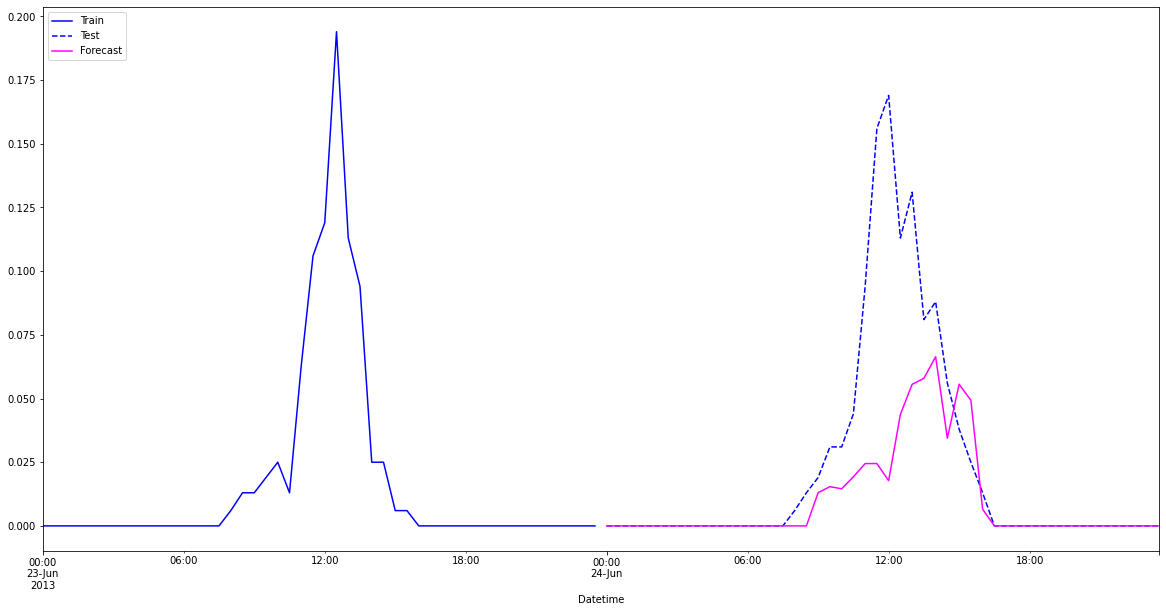

In [114]:
plot_forecast_exog(results_ar_24_i_1_ma_24_exogenas, 48)

### ARIMA  (48, 0, 48) + Variables exogenas

In [79]:
model_ar_48_i_0_ma_48_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog], order=(48,0,48))
results_ar_48_i_0_ma_48_Xspx = model_ar_48_i_0_ma_48_Xspx.fit()
results_ar_48_i_0_ma_48_Xspx.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:               ARIMA(48, 0, 48)   Log Likelihood               -4870.194
Date:                Mon, 13 Feb 2023   AIC                           9960.388
Time:                        03:50:37   BIC                          10813.079
Sample:                    07-01-2012   HQIC                         10241.426
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4246      0.022   -112.758      0.000      -2.467      -2.382
Temperatura             0.0068   3.41e-05    198.362      0.000       0.007       0.007
Viento                  0.0012   1.33e-05     88.303      0.000       0.001       0.001
Humedad                -0.0028    9.8e-06   -286.208      0.000      -0.003      -0.003
Presion_atmosferica     0.0030    2.5e-05    119.633      0.000       0.003       0.003
Visibilidad            -0.0003    3.8e-05     -7.432      0.000      -0.000      -0.000
Clear                  -0.5512      0.004   -130.166      0.000      -0.560      -0.543
Partly_sunny           -0.4772      0.004   -110.377      0.000      -0.486      -0.469
Passing_clouds         -0.5027      0.004   -115.303      0.000      -0.511      -0.494
Scattered_clouds       -0.4383      0.004   -100.684      0.000      -0.447      -0.430
Sunny                  -0.4552      0.004   -106.176      0.000      -0.464      -0.447
Hora                   -0.0008   3.21e-05    -26.033      0.000      -0.001      -0.001
Mes                     0.0009   3.62e-05     23.856      0.000       0.001       0.001
ar.L1                       -0      0.002         -0      1.000      -0.003       0.003
ar.L2                       -0      0.002         -0      1.000      -0.003       0.003
ar.L3                       -0      0.002         -0      1.000      -0.003       0.003
ar.L4                       -0      0.002         -0      1.000      -0.003       0.003
ar.L5                       -0      0.002         -0      1.000      -0.003       0.003
ar.L6                       -0      0.002         -0      1.000      -0.003       0.003
ar.L7                       -0      0.002         -0      1.000      -0.004       0.004
ar.L8                       -0      0.002         -0      1.000      -0.004       0.004
ar.L9                       -0      0.002         -0      1.000      -0.004       0.004
ar.L10                      -0      0.002         -0      1.000      -0.004       0.004
ar.L11                      -0      0.002         -0      1.000      -0.004       0.004
ar.L12                      -0      0.002         -0      1.000      -0.004       0.004
ar.L13                      -0      0.002         -0      1.000      -0.004       0.004
ar.L14                      -0      0.002         -0      1.000      -0.004       0.004
ar.L15                      -0      0.002         -0      1.000      -0.004       0.004
ar.L16                      -0      0.002         -0      1.000      -0.004       0.004
ar.L17                      -0      0.002         -0      1.000      -0.005       0.005
ar.L18                      -0      0.002         -0      1.000      -0.005       0.005
ar.L19                      -0      0.002         -0      1.000      -0.005       0.005
ar.L20                      -0      0.003         -0      1.000      -0.005       0.005
ar.L21                      -0      0.003         -0      1.000      -0.0

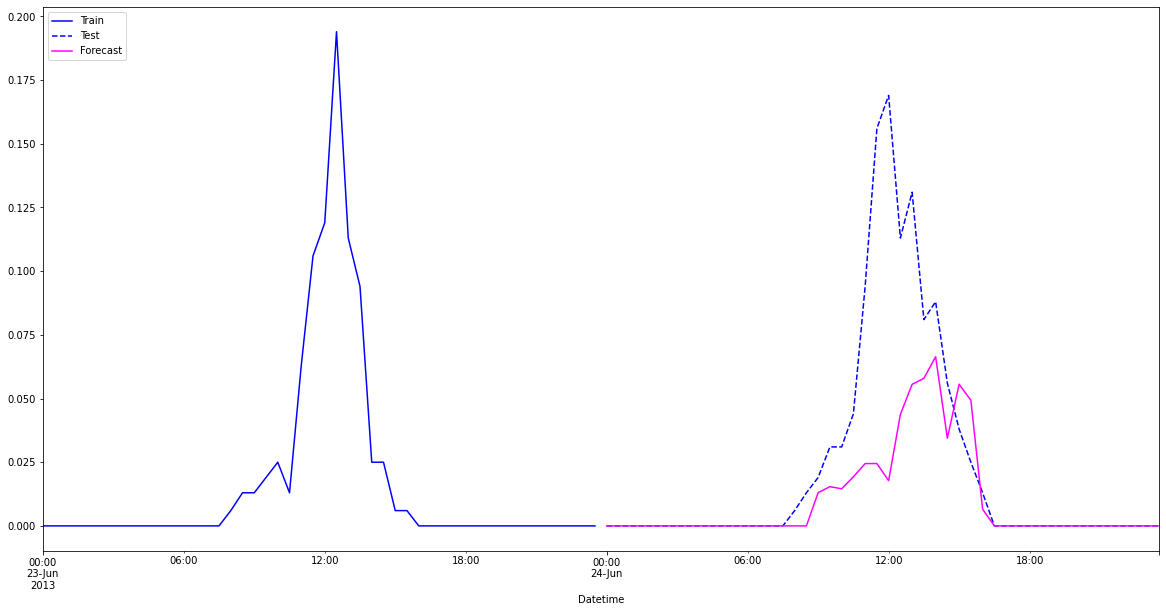

In [111]:
plot_forecast_exog(results_ar_48_i_0_ma_48_Xspx, 48)

In [ ]:
plot_forecast_exog(results_ar_48_i_0_ma_48_Xspx, 48)

## Prophet

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

In [44]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly

In [51]:
df_train_prophet = df_train.reset_index()
df_test_prophet = df_test.reset_index()

df_train_prophet.rename(columns={'Datetime': 'ds', 'Produccion': 'y'}, inplace = True)  
df_test_prophet.rename(columns={'Datetime': 'ds', 'Produccion': 'y'}, inplace = True)  
df_train_prophet.head()

,ds,y,Temperatura,Clima,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Hora,Mes,timeIndex
0,2012-07-01 00:00:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7,0
1,2012-07-01 00:30:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7,1
2,2012-07-01 01:00:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7,2
3,2012-07-01 01:30:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7,3
4,2012-07-01 02:00:00,0.0,12,Clear,7,54,1014,16,1.0,0.0,0.0,0.0,0.0,2,7,4


In [53]:
# instanciamos modelo
m = Prophet()

# fiteamos el modelo en TRAIN
m.fit(df_train_prophet)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


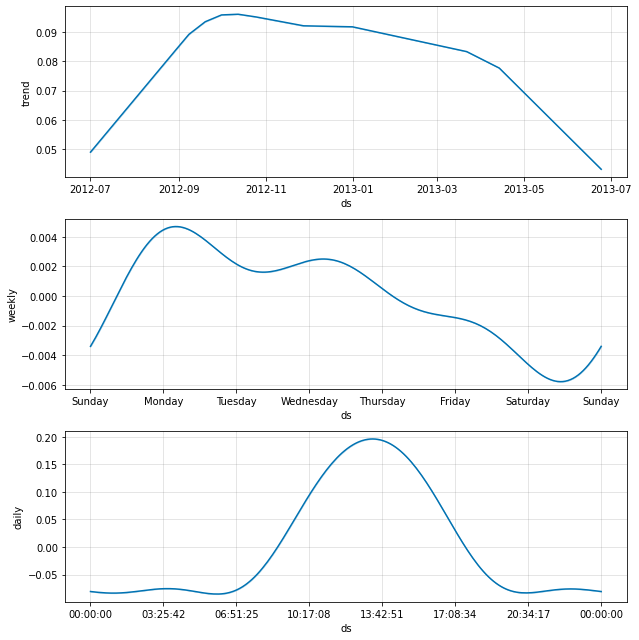

In [54]:
# predecimos en futuro
forecast = m.predict(df_test_prophet)

# para graficar, hacemos predict tambien en train
forecast_train = m.predict(df_train_prophet)

# #unimos los dos DFs para visualizar las dos partes, train-prediccion
forecast_final = pd.concat([forecast_train, forecast])

# #plot componentes del forecast
m.plot_components(forecast_train);

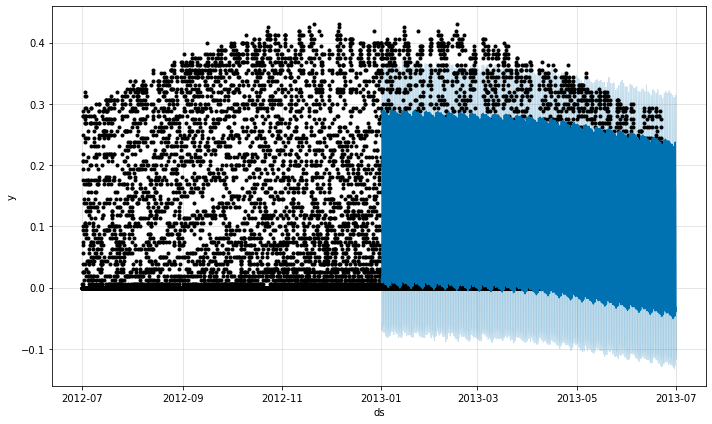

In [76]:
m.plot(forecast_final[forecast_final['ds'].dt.year==2013])
plt.show()

In [57]:
forecast_final

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-07-01 00:00:00,0.049074,-0.115969,0.042351,0.049074,0.049074,-0.084244,-0.084244,-0.084244,-0.080839,-0.080839,-0.080839,-0.003405,-0.003405,-0.003405,0.0,0.0,0.0,-0.035171
1,2012-07-01 00:30:00,0.049086,-0.111260,0.038323,0.049086,0.049086,-0.086049,-0.086049,-0.086049,-0.082817,-0.082817,-0.082817,-0.003232,-0.003232,-0.003232,0.0,0.0,0.0,-0.036963
2,2012-07-01 01:00:00,0.049098,-0.109829,0.031142,0.049098,0.049098,-0.086775,-0.086775,-0.086775,-0.083721,-0.083721,-0.083721,-0.003055,-0.003055,-0.003055,0.0,0.0,0.0,-0.037678
3,2012-07-01 01:30:00,0.049110,-0.115593,0.039883,0.049110,0.049110,-0.086085,-0.086085,-0.086085,-0.083212,-0.083212,-0.083212,-0.002873,-0.002873,-0.002873,0.0,0.0,0.0,-0.036975
4,2012-07-01 02:00:00,0.049122,-0.112917,0.045260,0.049122,0.049122,-0.084129,-0.084129,-0.084129,-0.081442,-0.081442,-0.081442,-0.002688,-0.002688,-0.002688,0.0,0.0,0.0,-0.035007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2013-06-30 21:30:00,0.039920,-0.111102,0.042568,0.039825,0.040036,-0.075286,-0.075286,-0.075286,-0.079394,-0.079394,-0.079394,0.004108,0.004108,0.004108,0.0,0.0,0.0,-0.035366
332,2013-06-30 22:00:00,0.039910,-0.107794,0.045041,0.039815,0.040026,-0.072948,-0.072948,-0.072948,-0.077143,-0.077143,-0.077143,0.004194,0.004194,0.004194,0.0,0.0,0.0,-0.033039
333,2013-06-30 22:30:00,0.039900,-0.108201,0.048886,0.039804,0.040016,-0.071872,-0.071872,-0.071872,-0.076146,-0.076146,-0.076146,0.004273,0.004273,0.004273,0.0,0.0,0.0,-0.031973
334,2013-06-30 23:00:00,0.039890,-0.104520,0.044899,0.039794,0.040007,-0.072358,-0.072358,-0.072358,-0.076704,-0.076704,-0.076704,0.004345,0.004345,0.004345,0.0,0.0,0.0,-0.032468
